# Peaks length

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display

# sns.set_style("whitegrid")
sns.set_style("white")
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def scores(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[4]
    except:
        return np.zeros(0)  # Empty file

def positions(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[0], tf[1], tf[2]
    except:
        return [], [], []  # Empty file

In [3]:
def find_peak_files(path, suffix, cells, modifications, replicates, fdrs):
    df = pd.DataFrame(
        columns=['modification', 'cell', 'replicate', 'fdr', 'file'],
        dtype=object
    )
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        mod = next((m for m in modifications if m in f), None)
        cell = next((cc for cc in cells if cc in f), None)
        rep = next((r for r in replicates if r in f), None)
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        if mod:
            df.loc[len(df)] = (mod, cell, rep, fdr, os.path.join(path, f))
    return df

In [4]:
def load_peaks(df, lowq=.01, highq=.99):
    dfs = []
    for _, (m, t, file) in tqdm(df[['modification', 'tool', 'file']].iterrows()):
        peaks_info = []
        chromosomes, starts, ends = positions(file)
        peaks_info.extend((m, t, file, chr, start, end, length)
                          for chr, start, end, length in zip(chromosomes, starts, ends, bedl(file)))
        t = pd.DataFrame(
            peaks_info,
            columns=['modification', 'tool', 'file', 'chromosome', 'start', 'end', 'length']
        )
        t = t.sample(min(len(t), 10_000))
        # Ignore extreme peaks
        t = t[(t['length'].quantile(lowq) <= t['length']) &
              (t['length'] <= t['length'].quantile(highq))].copy()
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [5]:
def plot_boxes(df, value, title, hue='modification', bar=False, log=False, figx=None, figy=None,
               minx=50, maxx=1e4, order=None):
    plt.figure(figsize=(figx or 8, figy or int(2 + 0.15 * len(set(df[hue])))))
    ax = plt.axes()
    if bar:
        if log:
            g_results = sns.barplot(data=df, y=hue, x=value, ax=ax, order=order, orient='h', capsize=.1, errwidth=2, log=True)
        else:
            g_results = sns.barplot(data=df, y=hue, x=value, ax=ax, order=order, orient='h', capsize=.05, errwidth=2)
    else:
        g_results = sns.boxplot(data=df, y=hue, x=value, ax=ax, order=order, showfliers=False, orient='h')
    sample_count = list(
        filter(lambda x: minx <= x <= maxx,
               [10, 100,  1000, 10_000, 100_000, 1_000_000])
    )
    if log:
        g_results.set(xscale='log')
        g_results.set(xticks=sample_count)
        g_results.set(xticklabels=sample_count)
    ax.set_xlim(minx, maxx)
    ax.title.set_text(title)
    plt.tight_layout()

In [6]:
def plot_kde(te, value, title, hue='modification', order=None, figx=8, figy=3, minx=1, maxx=1e5, maxy=2.5):
    plt.figure(figsize=(figx, figy))
    ax = plt.axes()
    g_results = sns.kdeplot(data=te, x=value, hue=hue,
                            common_norm=False,
                            log_scale=True,
                            hue_order=order)
    g_results.set(xscale='log')
    g_results.set_ylim(0, maxy)
    g_results.set_xlim(minx, maxx)
    ax.title.set_text(title)
    plt.tight_layout()

In [7]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')

# hg38 genes length and distance between genes

In [14]:
GTF = os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf')
gtf_df = pd.read_csv(os.path.join(GSE26320_PATH, GTF), sep='\t', comment='#',
                     names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)
gtf_df.sample(3)

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


chromosome      db        type      start        end point1 strand  \
926221        chr4  HAVANA  transcript  185657513  185775441      .      -   
1517253       chr8  HAVANA         UTR  143691223  143691232      .      +   
956398        chr5  HAVANA        exon   55289270   55289428      .      -   

        point2             gene_id       gene_type gene_name level  
926221       .  ENSG00000154556.20  protein_coding    SORBS2     2  
1517253      .  ENSG00000181135.16  protein_coding    ZNF707     2  
956398       .  ENSG00000067248.11  protein_coding     DHX29     2

GTF all genes lengths


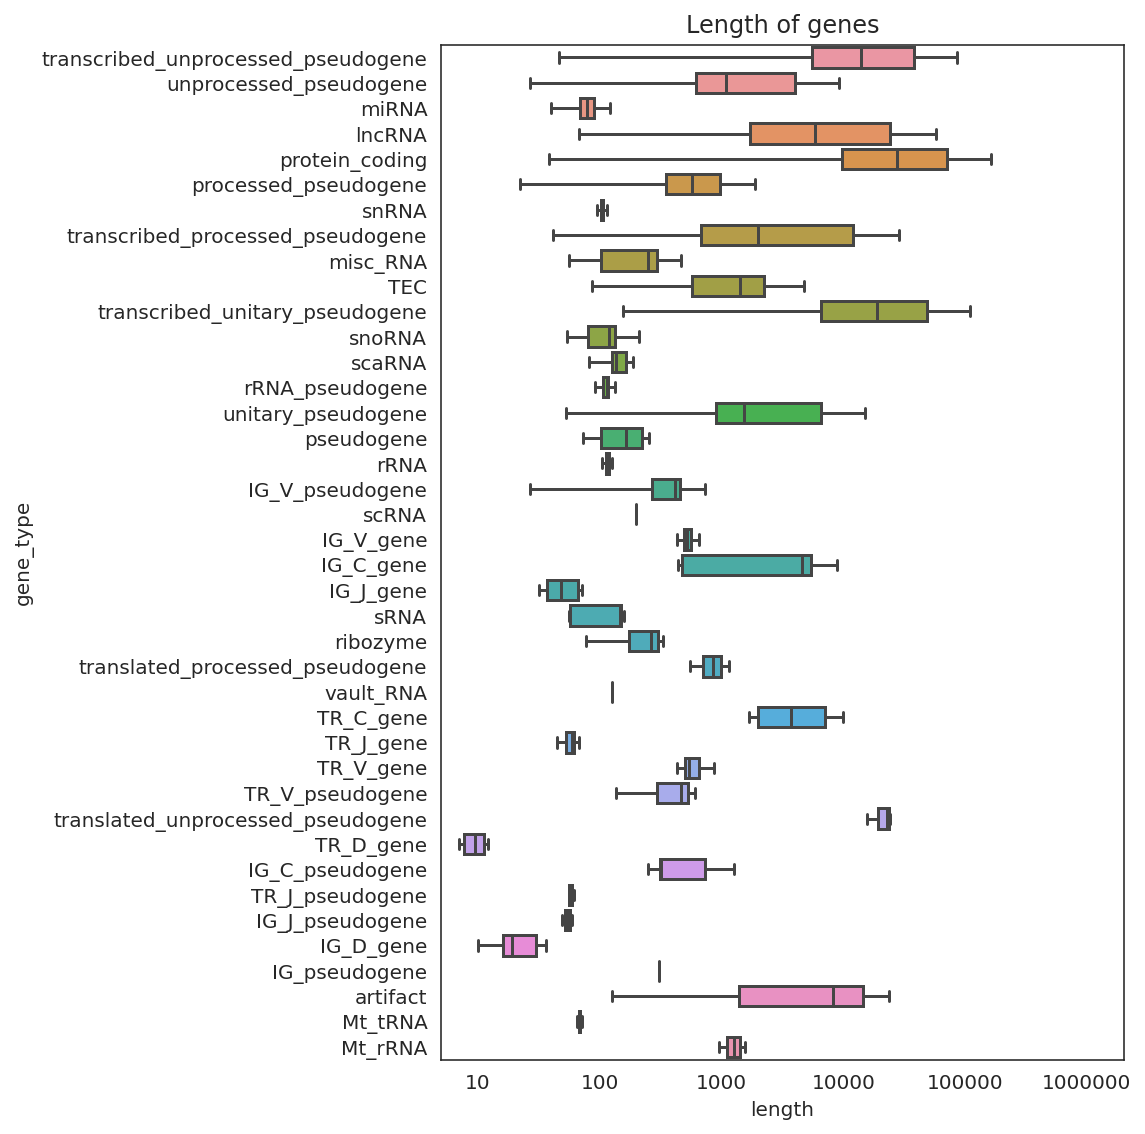

In [15]:
gtf_df['length'] = gtf_df['end'] - gtf_df['start']
gtf_df[gtf_df['type'] == 'gene'].sample(5)
print('GTF all genes lengths')
gtf_genes_df = gtf_df[gtf_df['type'] == 'gene'].copy()
plot_boxes(gtf_genes_df, 'length', 'Length of genes',
           hue='gene_type',
           log=True, minx=5, maxx=2_000_000)
plt.show()

GTF all genes lengths


/tmp/ipykernel_529403/2281812162.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g_results = sns.kdeplot(data=te, x=value, hue=hue,
/tmp/ipykernel_529403/2281812162.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g_results = sns.kdeplot(data=te, x=value, hue=hue,
/tmp/ipykernel_529403/2281812162.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g_results = sns.kdeplot(data=te, x=value, hue=hue,


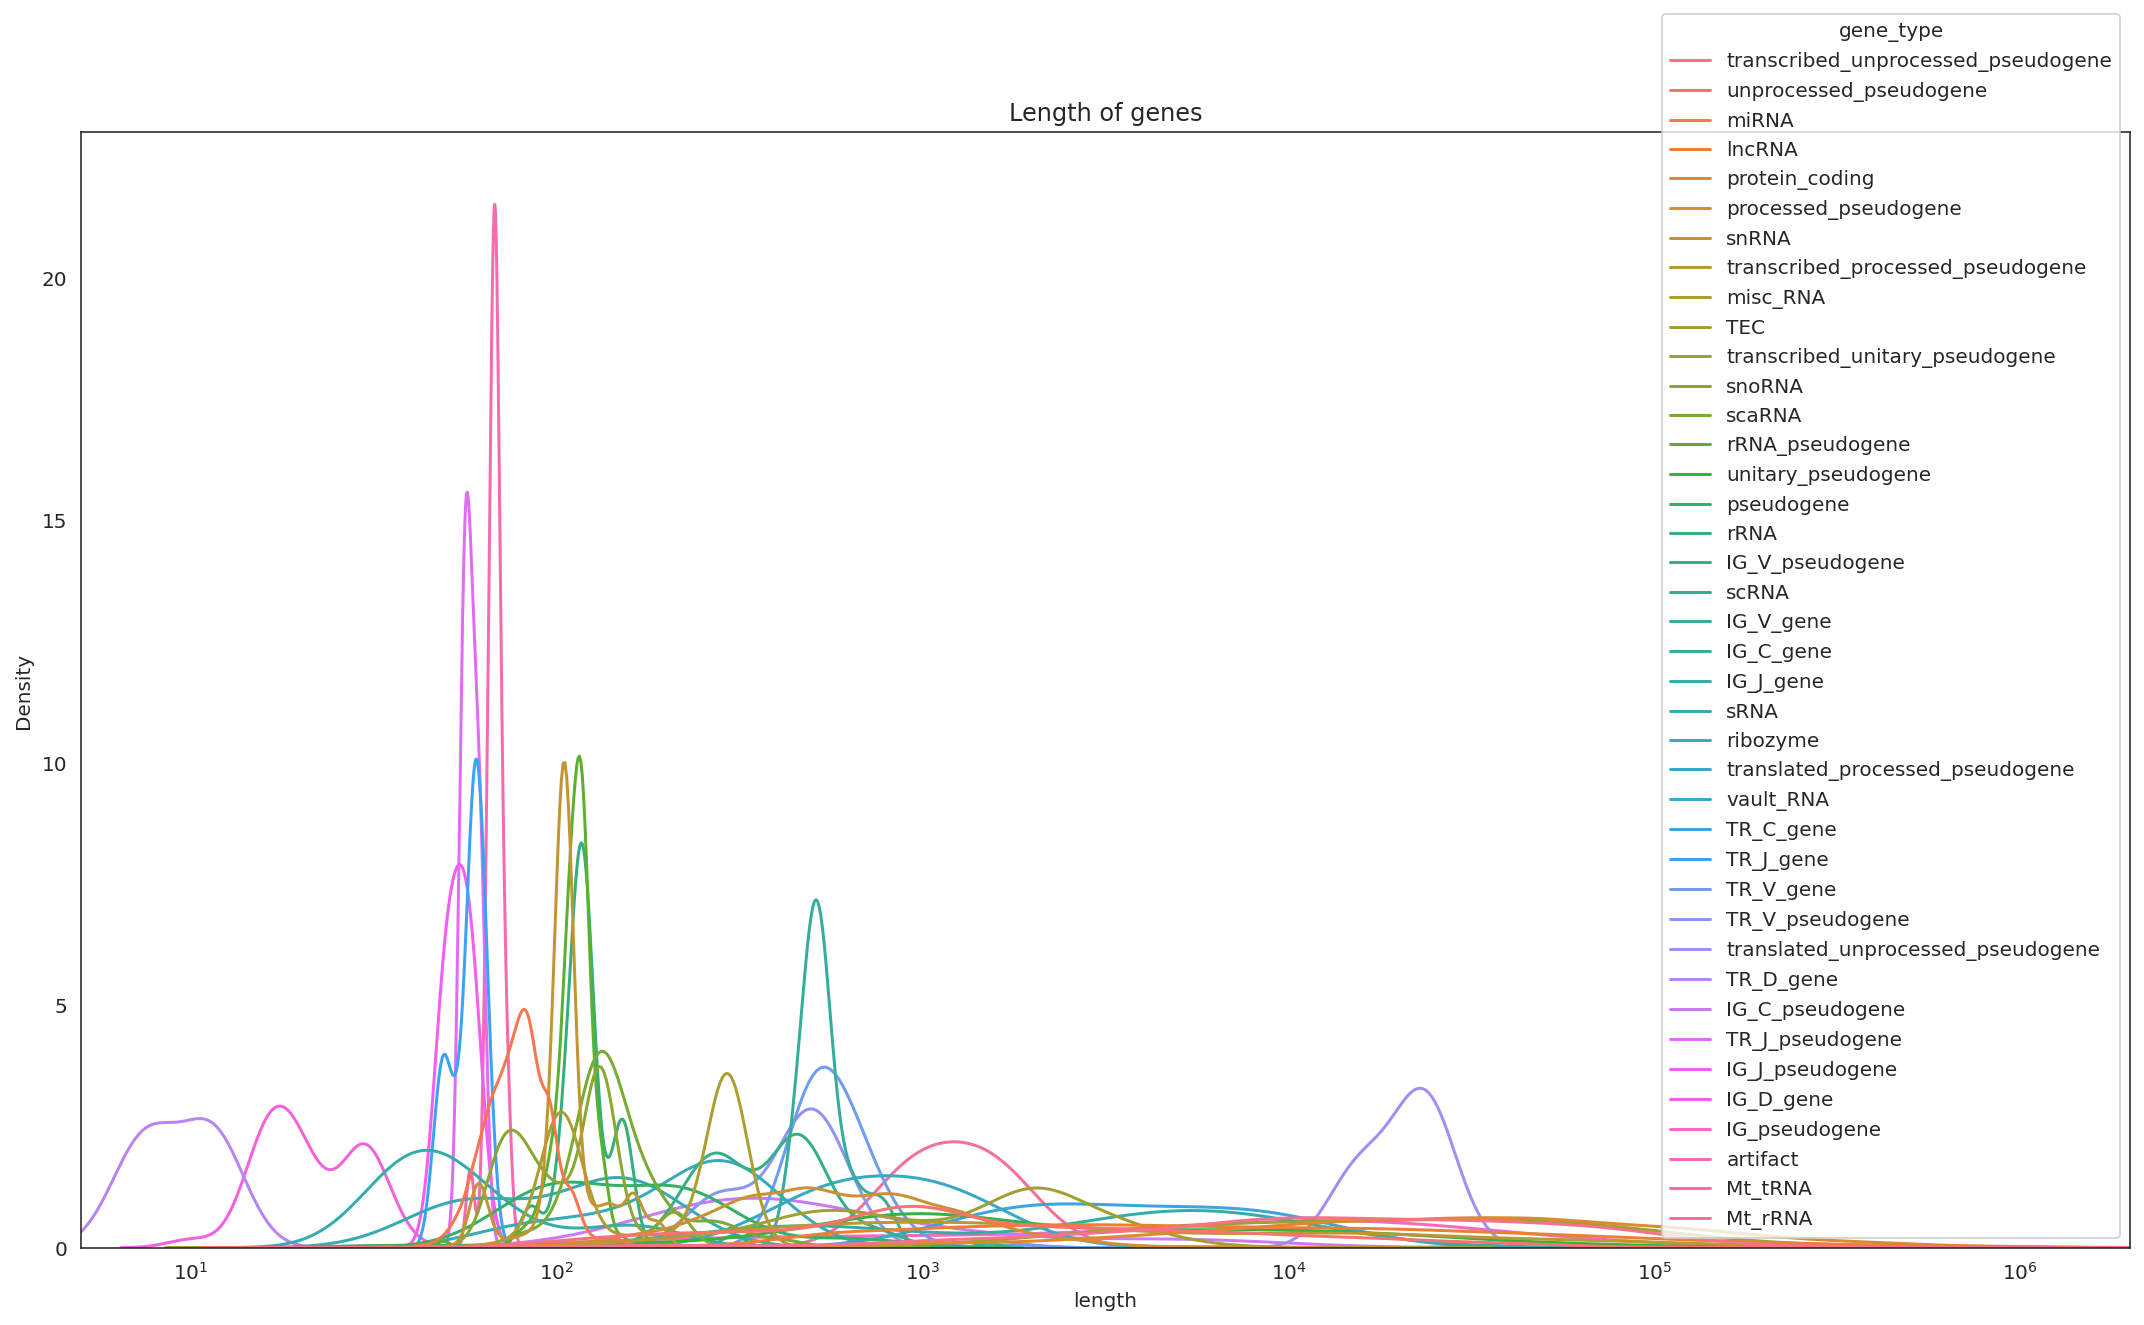

In [16]:
print('GTF all genes lengths')
plot_kde(gtf_genes_df, 'length', 'Length of genes', hue='gene_type', figx=15, figy=10, minx=5, maxx=2e6, maxy=23)
plt.show()

GTF genes lengths


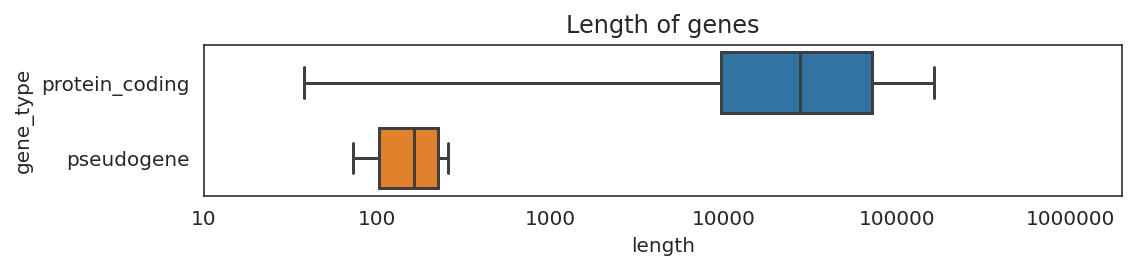

In [17]:
GENES_TYPES = ['protein_coding', 'pseudogene']
# GENES_TYPES = ['protein_coding']
print('GTF genes lengths')
gtf_genes_df2 = gtf_genes_df[gtf_genes_df['gene_type'].isin(GENES_TYPES)].copy()
plot_boxes(gtf_genes_df2, 'length', 'Length of genes', hue='gene_type',
           log=True, minx=10, maxx=2_000_000,
           order=['protein_coding', 'pseudogene'])
gtf_genes_df2['file'] = 'gtf'
gtf_genes_df2['tool'] = 'gtf'
plt.show()

GTF all genes lengths


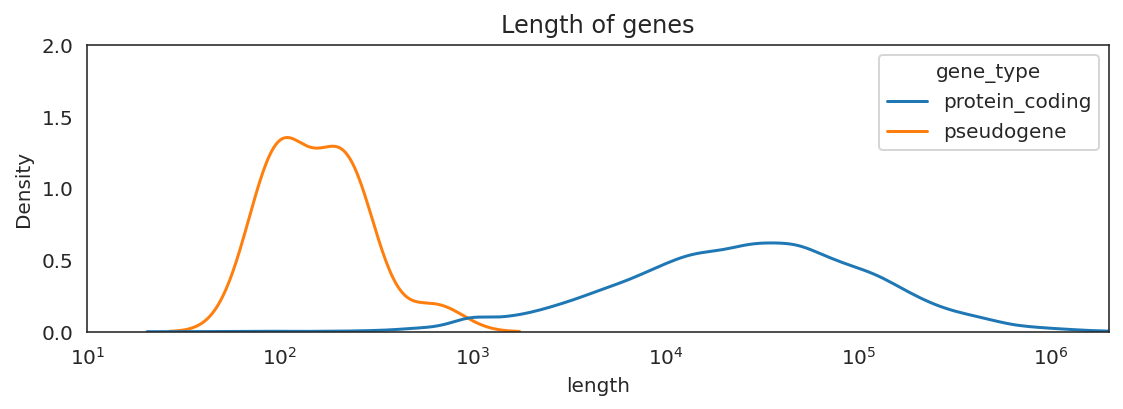

In [18]:
print('GTF all genes lengths')
plot_kde(gtf_genes_df2, 'length', 'Length of genes', hue='gene_type', order=GENES_TYPES,
         minx=10, maxx=2e6, maxy=2)
plt.show()

# Encodeproject.org ATAC/TFs/ChIPseq

`xargs -L 1 curl -O -J -L < files.txt` and rename using `metadata.csv`
```
cd ~/data/2022_atacseq
for F in *.bed; do echo $F; mv $F $(grep "^${F/.bed/}" metadata.tsv | awk  -v FS='\t' '{printf("%s_%s_%s", $1, $11, "ATAC")}'  | sed 's# #_#g').bed; done

cd ~/data/2022_chipseq_narrow
for F in *.bed; do echo $F; mv $F $(grep "^${F/.bed/}" metadata.tsv | awk  -v FS='\t' '{printf("%s_%s_%s", $1, $11, $23)}'  | sed -E 's#[^a-zA-Z0-9]+#_#g').bed; done

cd ~/data/2022_chipseq_broad
for F in *.bed; do echo $F; mv $F $(grep "^${F/.bed/}" metadata.tsv | awk  -v FS='\t' '{printf("%s_%s_%s", $1, $11, $23)}'  | sed -E 's#[^a-zA-Z0-9]+#_#g').bed; done

# Simple analysis
for F in *.bed; do echo $(cat $F | awk '{N+=1;L+=$3-$2} END {printf("%d\n", L/N)}') $F; done | sort -k1,1n
```

In [19]:
ENCODE_REPROCESSED_PATH = os.path.expanduser('~/data/2022_atac_chipseq_encode')

!mkdir -p {ENCODE_REPROCESSED_PATH}/pics

In [20]:
def plot_length_per_file(df, value):
    for t, m in product(set(df['tool']), set(df['modification'])):
        ts = df[(df['tool'] == t) & (df['modification'] == m)]
        if len(ts) == 0:
            continue
        print(t, m, len(set(ts['file'])))
        plt.figure(figsize=(12, 8))
        # Plot
        ax = plt.axes()
        sns.violinplot(data=ts, x='file', y=value, ax=ax, scale='width')
        ax.title.set_text(f'{m} {t}')
        plt.xticks(rotation=90, fontsize=7)
        plt.xlabel('file')
        plt.tight_layout()
        plt.show()

# Reprocessed with MACS2

In [21]:
ENCODE_REPROCESSED_CELLS = ['']
ENCODE_REPROCESSED_MODIFICATIONS = [
    'ATAC', 'CTCF', 'H2AFZ', 'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K27me3', 'H3K36me3'
]
# Joint MACS2 for narrow and MACS2 broad for broad peaks
FDRS = ['']
df_encodeprojectorg_reprocessed = pd.concat(
    [
        find_peak_files(
            ENCODE_REPROCESSED_PATH + '/macs2', '.narrowPeak', ENCODE_REPROCESSED_CELLS, ENCODE_REPROCESSED_MODIFICATIONS,
            ['rep1', 'rep2'], FDRS
        ),
        find_peak_files(

            ENCODE_REPROCESSED_PATH + '/macs2', '.broadPeak', ENCODE_REPROCESSED_CELLS, ENCODE_REPROCESSED_MODIFICATIONS,
            ['rep1', 'rep2'], FDRS
        )]
)
df_encodeprojectorg_reprocessed['tool'] = 'MACS2'
# df_encode_reprocessed.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [22]:
df_encodeprojectorg_reprocessed_peaks = load_peaks(df_encodeprojectorg_reprocessed)
display(df_encodeprojectorg_reprocessed_peaks.sample(5))

0it [00:00, ?it/s]

modification   tool                                               file  \
51037      H3K4me1  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   
11352        H2AFZ  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   
4002          CTCF  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   
9883          CTCF  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   
15107        H2AFZ  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   

      chromosome      start        end  length  
51037       chr6   90154870   90155153     283  
11352      chr19   51108631   51109187     556  
4002        chr8  134886464  134886720     256  
9883        chr1    9267177    9267382     205  
15107      chr11  106875168  106875386     218

Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED MACS2


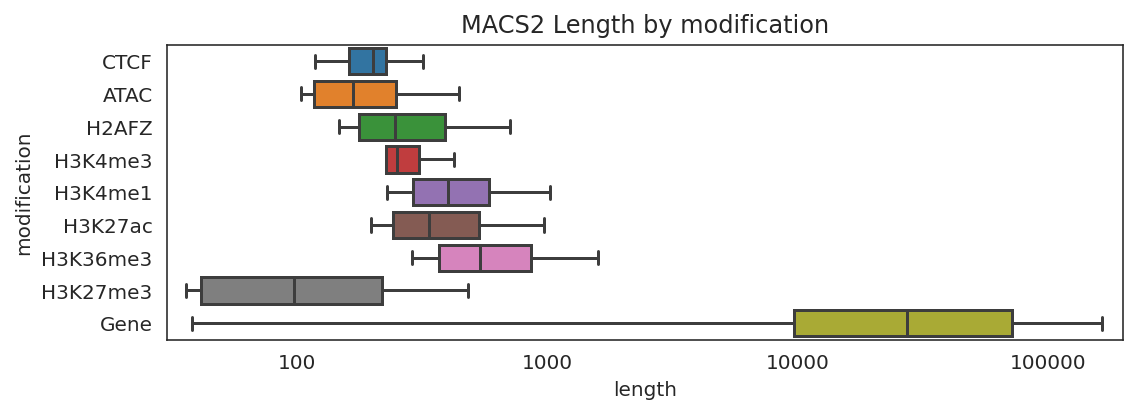

In [23]:
t = gtf_genes_df2[gtf_genes_df2['gene_type']=='protein_coding'].copy().rename(
    {'gene_type': 'modification'}, axis=1
)
t['modification'] = 'Gene'
print('Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED MACS2')
plot_boxes(pd.concat([df_encodeprojectorg_reprocessed_peaks, t]).reset_index(),
           'length', 'MACS2 Length by modification',
           log=True, figx=8, figy=3, minx=30, maxx=2e5,
           order=['CTCF', 'ATAC', 'H2AFZ', 'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3', 'Gene'])
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsMACS2_1.pdf', bbox_inches='tight', dpi=300)
plt.show()

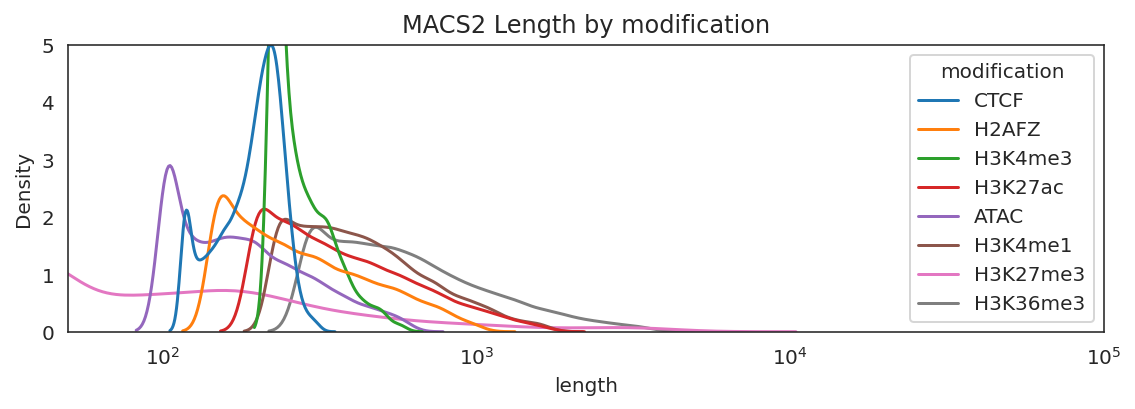

In [24]:
plot_kde(df_encodeprojectorg_reprocessed_peaks, 'length', 'MACS2 Length by modification', minx=50, maxx=1e5, maxy=5)
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsMACS2_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Encode reprocessed with SPAN

In [25]:
df_encodeprojectorg_reprocessed_span = find_peak_files(
    ENCODE_REPROCESSED_PATH + '/span', '.peak', ENCODE_REPROCESSED_CELLS, ENCODE_REPROCESSED_MODIFICATIONS,
    ['rep1', 'rep2'],
    FDRS
)
df_encodeprojectorg_reprocessed_span['tool'] = 'SPAN'
df_encodeprojectorg_reprocessed_span.sample(3)

  0%|          | 0/11 [00:00<?, ?it/s]

modification cell replicate fdr  \
7      H3K27ac           None       
4     H3K27me3           None       
1      H3K4me1           None       

                                                file  tool  
7  /home/jetbrains/data/2022_atac_chipseq_encode/...  SPAN  
4  /home/jetbrains/data/2022_atac_chipseq_encode/...  SPAN  
1  /home/jetbrains/data/2022_atac_chipseq_encode/...  SPAN

In [26]:
df_encodeprojectorg_reprocessed_span_peaks = load_peaks(df_encodeprojectorg_reprocessed_span)
display(df_encodeprojectorg_reprocessed_span_peaks.sample(5))

0it [00:00, ?it/s]

modification  tool                                               file  \
5296          ATAC  SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
58188        H2AFZ  SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
71722      H3K27ac  SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
1005          ATAC  SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
71179      H3K27ac  SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   

      chromosome      start        end  length  
5296       chr10   50659840   50660500     660  
58188      chr15   64774709   64776184    1475  
71722       chr9  136561816  136571798    9982  
1005       chr12  112998927  112999272     345  
71179       chr4  143184423  143186147    1724

Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED SPAN


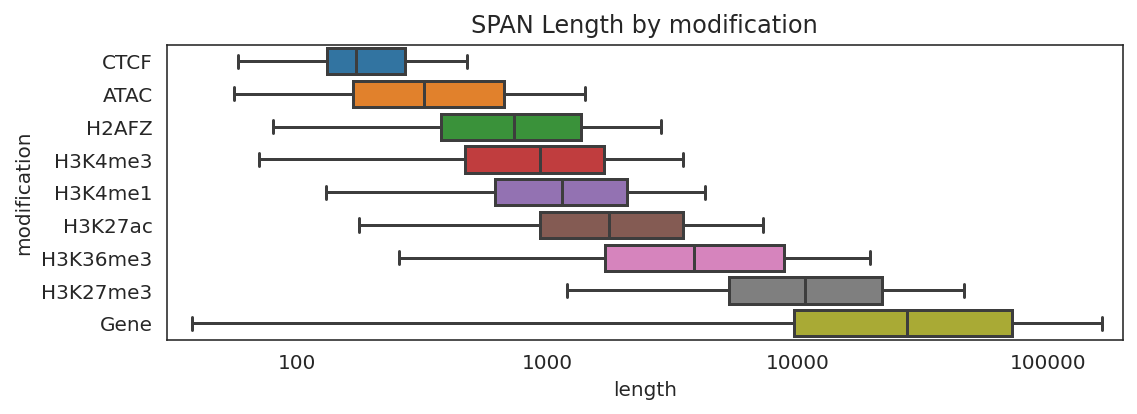

In [27]:
t = gtf_genes_df2[gtf_genes_df2['gene_type']=='protein_coding'].copy().rename(
    {'gene_type': 'modification'}, axis=1
)
t['modification'] = 'Gene'

print('Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED SPAN')
plot_boxes(pd.concat([df_encodeprojectorg_reprocessed_span_peaks, t]).reset_index(),
           'length', 'SPAN Length by modification',
           log=True, figx=8, figy=3, minx=30, maxx=2e5,
           order=['CTCF', 'ATAC', 'H2AFZ', 'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3', 'Gene'])
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsSPAN_1.pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_529403/2281812162.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g_results.set_xlim(minx, maxx)


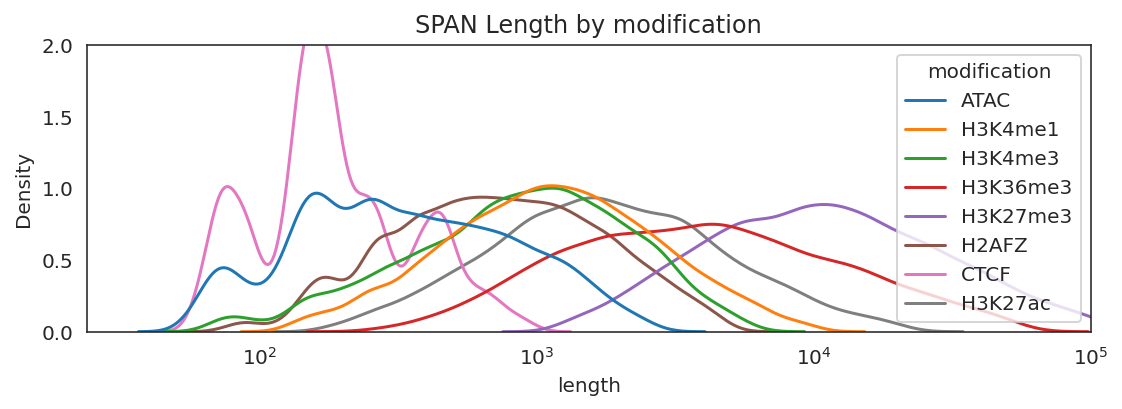

In [28]:
plot_kde(df_encodeprojectorg_reprocessed_span_peaks, 'length', 'SPAN Length by modification', minx=0, maxx=1e5, maxy=2)
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsSPAN_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Encode reprocessed with SICER


In [29]:
# Joint SICER with control and without control peaks
FDRS = ['']
df_encodeprojectorg_reprocessed_sicer = find_peak_files(
    ENCODE_REPROCESSED_PATH + '/sicer', '', ENCODE_REPROCESSED_CELLS, ENCODE_REPROCESSED_MODIFICATIONS,
    ['rep1', 'rep2'], FDRS
)
df_encodeprojectorg_reprocessed_sicer['tool'] = 'SICER'
df_encodeprojectorg_reprocessed_sicer

  0%|          | 0/8 [00:00<?, ?it/s]

modification cell replicate fdr  \
0         CTCF           None       
1        H2AFZ           None       
2     H3K36me3           None       
3     H3K27me3           None       
4      H3K27ac           None       
5         ATAC           None       
6      H3K4me3           None       
7      H3K4me1           None       

                                                file   tool  
0  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
1  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
2  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
3  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
4  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
5  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
6  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER  
7  /home/jetbrains/data/2022_atac_chipseq_encode/...  SICER

In [30]:
df_encodeprojectorg_reprocessed_sicer_peaks = load_peaks(df_encodeprojectorg_reprocessed_sicer)
display(df_encodeprojectorg_reprocessed_sicer_peaks.sample(5))

0it [00:00, ?it/s]

modification   tool                                               file  \
67051      H3K4me3  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   
26260     H3K36me3  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   
75671      H3K4me1  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   
53886         ATAC  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   
61129      H3K4me3  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   

      chromosome      start        end  length  
67051      chr16   10555600   10560799    5199  
26260       chr5  123607400  123609999    2599  
75671       chr2   55415400   55418799    3399  
53886      chr19   21020200   21021199     999  
61129       chr3   49898400   49899799    1399

Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED SICER


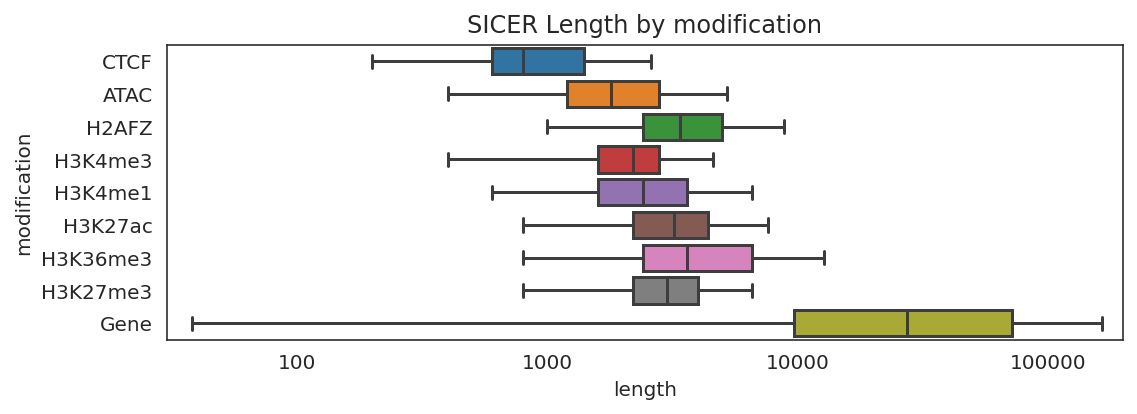

In [31]:
t = gtf_genes_df2[gtf_genes_df2['gene_type']=='protein_coding'].copy().rename(
    {'gene_type': 'modification'}, axis=1
)
t['modification'] = 'Gene'

print('Encodeproject.org ATAC/TFs/ChIPseq SELECTED REPROCESSED SICER')
plot_boxes(pd.concat([df_encodeprojectorg_reprocessed_sicer_peaks, t]).reset_index(),
           'length', 'SICER Length by modification',
           log=True, figx=8, figy=3, minx=30, maxx=2e5,
           order=['CTCF', 'ATAC', 'H2AFZ', 'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3', 'Gene'])
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsSICER_1.pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_529403/2281812162.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g_results.set_xlim(minx, maxx)


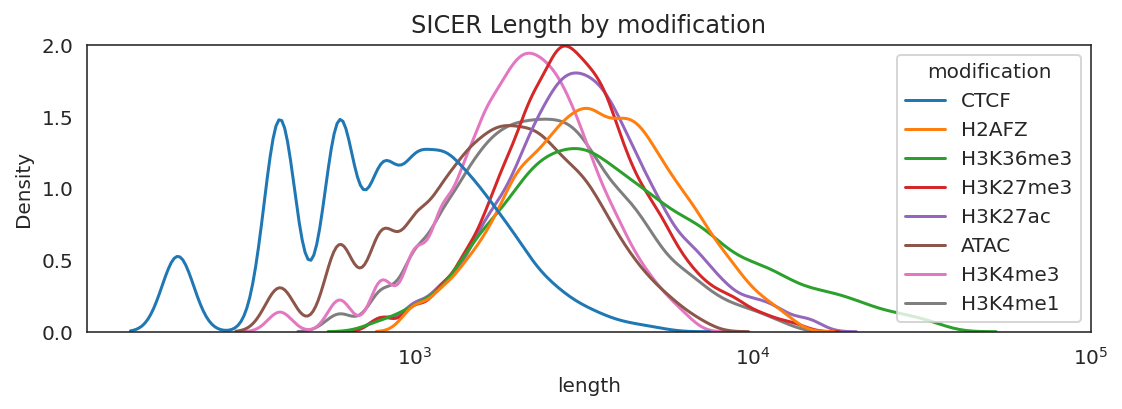

In [32]:
plot_kde(df_encodeprojectorg_reprocessed_sicer_peaks, 'length', 'SICER Length by modification', minx=0, maxx=1e5, maxy=2)
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengthsSICER_2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [33]:
t = pd.concat([df_encodeprojectorg_reprocessed_peaks,
               df_encodeprojectorg_reprocessed_span_peaks,
               df_encodeprojectorg_reprocessed_sicer_peaks]).reset_index(drop=True)
t.sample(5)

modification   tool                                               file  \
68788          ATAC   SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
48645       H3K4me1  MACS2  /home/jetbrains/data/2022_atac_chipseq_encode/...   
190903         ATAC  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   
103910     H3K27me3   SPAN  /home/jetbrains/data/2022_atac_chipseq_encode/...   
206782      H3K4me3  SICER  /home/jetbrains/data/2022_atac_chipseq_encode/...   

       chromosome      start        end  length  
68788        chr4   99851000   99852371    1371  
48645        chr2  191170080  191170308     228  
190903      chr14   99594800   99595399     599  
103910       chr7   35229014   35288139   59125  
206782      chr19   29579600   29581399    1799

In [34]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

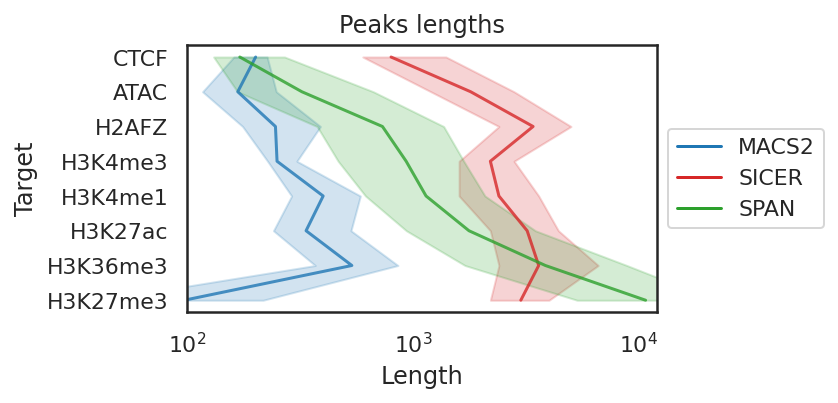

In [35]:
sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H2AFZ', 'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         palette=TOOLS_PALETTE,
                         errorbar=('pi', 50),
                         # marker='o', markersize=1
                         )
g_results.axes.set_yticks(range(8), minor=False)
g_results.axes.set_yticklabels(reversed(['CTCF', 'ATAC', 'H2AFZ', 'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(100, 1.2e4)
g_results.axes.title.set_text(f'Peaks lengths')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# GSE26320_RAW reprocessed

In [30]:
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']
GSE26320_REPS = ['rep1', 'rep2']

In [31]:
GSE26320_MACS2_DIR = os.path.join(GSE26320_PATH, os.path.expanduser('macs2'))

MACS2_FDRS = ['0.05']
df_gse26320_macs2 = find_peak_files(
    GSE26320_MACS2_DIR, '.narrowPeak', GSE26320_CELLS, GSE26320_MODIFICATIONS, GSE26320_REPS, MACS2_FDRS
)
df_gse26320_macs2['tool'] = 'MACS2'

df_gse26320_macs2broad = find_peak_files(
    GSE26320_MACS2_DIR, '.broadPeak', GSE26320_CELLS, GSE26320_MODIFICATIONS, GSE26320_REPS, MACS2_FDRS
)
df_gse26320_macs2broad['tool'] = 'MACS2 broad'

GSE26320_SICER_DIR = os.path.join(GSE26320_PATH, os.path.expanduser('sicer'))
GSE26320_SICER_FDRS = ['0.01']
df_gse26320_sicer = find_peak_files(
    GSE26320_SICER_DIR, 'summary-FDR', GSE26320_CELLS, GSE26320_MODIFICATIONS,
    GSE26320_REPS, GSE26320_SICER_FDRS
)
df_gse26320_sicer['tool'] = 'SICER'

GSE26320_SPAN_DIR = os.path.join(GSE26320_PATH, os.path.expanduser('span'))
GSE26320_SPAN_FDRS = ['0.05']
df_gse26320_span = find_peak_files(
    GSE26320_SPAN_DIR, '.peak', GSE26320_CELLS, GSE26320_MODIFICATIONS, GSE26320_REPS, GSE26320_SPAN_FDRS
)
df_gse26320_span['tool'] = 'SPAN'

df_gse26320 = pd.concat(
    [df_gse26320_macs2, df_gse26320_macs2broad, df_gse26320_sicer, df_gse26320_span]
).reset_index(drop=True)
df_gse26320.sample(10)

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

modification   cell replicate   fdr  \
284      H3K4me3  Huvec      rep1  0.05   
232     H3K27me3   HSMM      rep1  0.01   
18       H3K4me3   K562      rep1  0.05   
201      H3K4me1  Huvec      rep2  0.01   
211      H3K4me1   K562      rep2  0.01   
152     H3K27me3   NHEK      rep2  None   
87      H3K27me3   HMEC      rep1  None   
7        H3K4me3   HMEC      rep1  0.05   
193     H3K27me3     H1      rep2  0.01   
306      H3K4me3   NHEK      rep2  0.05   

                                                  file         tool  
284  /home/jetbrains/data/2023_GSE26320/span/GSM646...         SPAN  
232  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...        SICER  
18   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...        MACS2  
201  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...        SICER  
211  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...        SICER  
152  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  MACS2 broad  
87   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  MACS2 broad  
7    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...        MACS2  
193  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...        SICER  
306  /home/jetbrains/data/2023_GSE26320/span/GSM646...         SPAN

In [32]:
df_gse26320_peaks = load_peaks(df_gse26320)
df_gse26320_peaks

0it [00:00, ?it/s]

modification   tool  \
0           H3K27me3  MACS2   
1           H3K27me3  MACS2   
2           H3K27me3  MACS2   
3           H3K27me3  MACS2   
4           H3K27me3  MACS2   
...              ...    ...   
3111176     H3K27me3   SPAN   
3111177     H3K27me3   SPAN   
3111178     H3K27me3   SPAN   
3111179     H3K27me3   SPAN   
3111180     H3K27me3   SPAN   

                                                      file chromosome  \
0        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...       chr1   
1        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...       chr5   
2        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...       chr6   
3        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...       chr9   
4        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...       chr6   
...                                                    ...        ...   
3111176  /home/jetbrains/data/2023_GSE26320/span/GSM646...      chr17   
3111177  /home/jetbrains/data/2023_GSE26320/span/GSM646...       chr2   
3111178  /home/jetbrains/data/2023_GSE26320/span/GSM646...       chr2   
3111179  /home/jetbrains/data/2023_GSE26320/span/GSM646...      chr19   
3111180  /home/jetbrains/data/2023_GSE26320/span/GSM646...       chr5   

             start        end length  
0         18724373   18724563    190  
1        173342343  173342505    162  
2        167717715  167717877    162  
3         94712842   94713222    380  
4         33994226   33994388    162  
...            ...        ...    ...  
3111176   56797027   56797450    423  
3111177  236209534  236210940   1406  
3111178   39719592   39721064   1472  
3111179    2305289    2306454   1165  
3111180   73449093   73452167   3074  

[3111181 rows x 7 columns]

GSE26320 REPROCESSED  Length of peaks


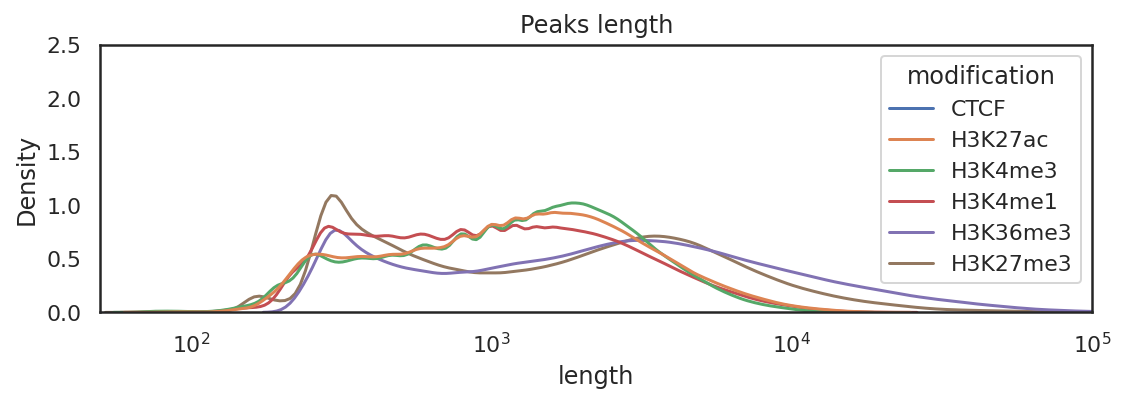

In [33]:
print('GSE26320 REPROCESSED  Length of peaks')
plot_kde(df_gse26320_peaks, 'length', 'Peaks length',
         order=['CTCF', 'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
         minx=5e1, maxx=1e5)
plt.savefig(f'{GSE26320_PATH}/pics/modifications_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

MACS2


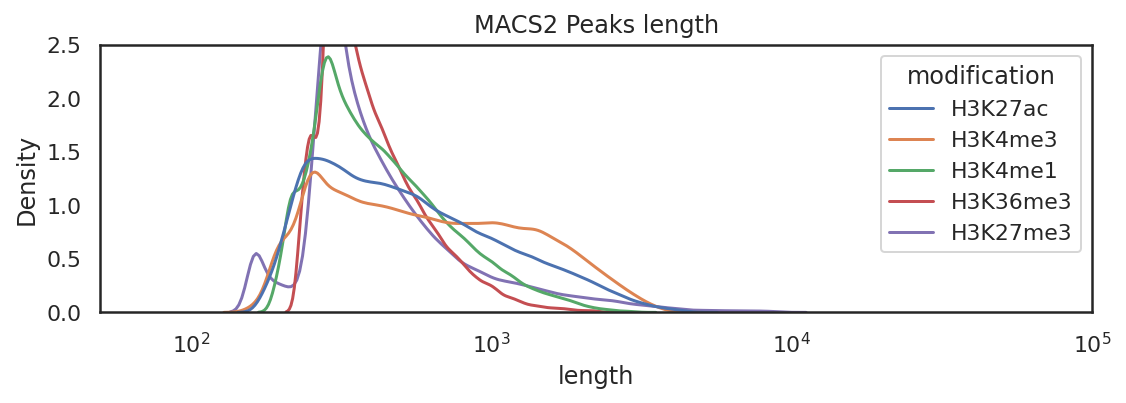

MACS2 broad


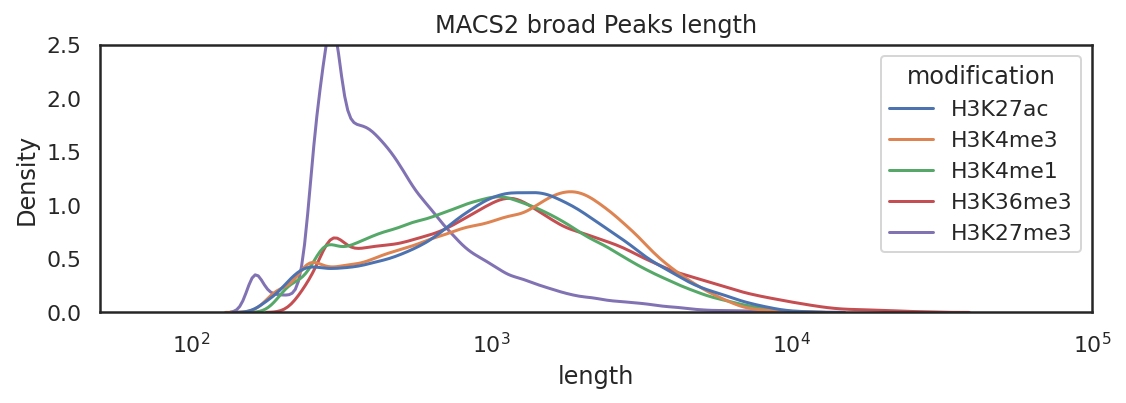

SPAN


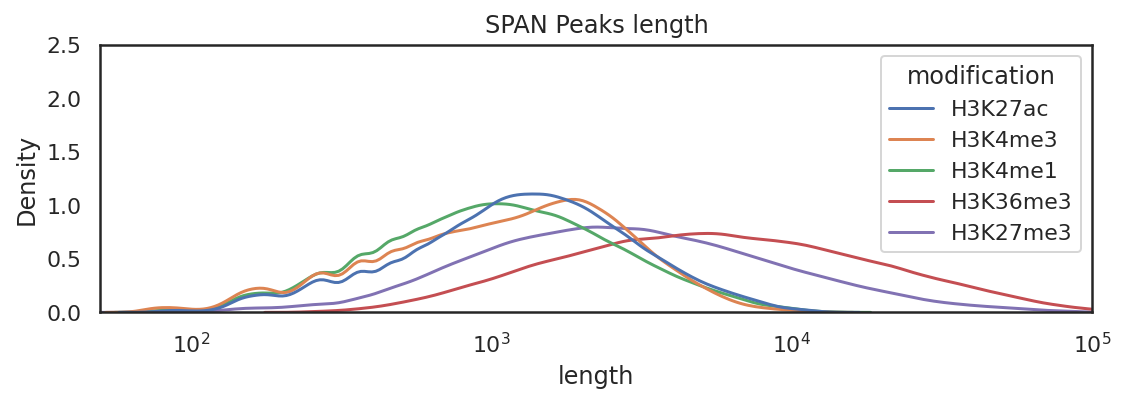

SICER


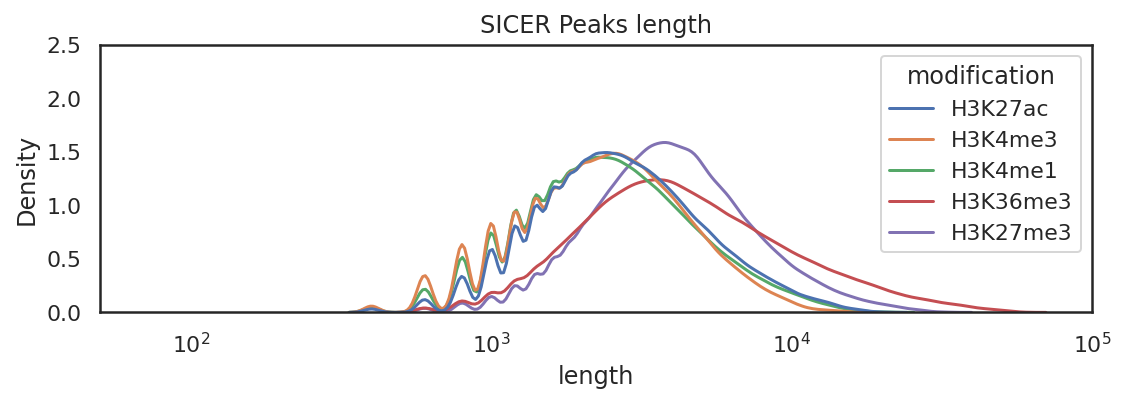

In [34]:
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_kde(df_gse26320_peaks[df_gse26320_peaks['tool'] == tool], 'length', f'{tool} Peaks length',
             order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
             minx=5e1, maxx=1e5)
    plt.savefig(f'{GSE26320_PATH}/pics/modifications_{tool}_lengths.pdf', bbox_inches='tight', dpi=300)
    plt.show()

GSE26320 REPROCESSED Length of peaks


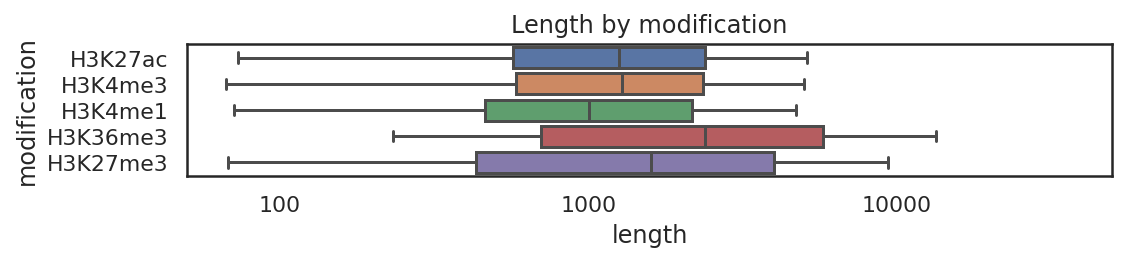

In [37]:
print('GSE26320 REPROCESSED Length of peaks')
plot_boxes(df_gse26320_peaks, 'length', 'Length by modification',
           log=True, bar=False, minx=5e1, maxx=5e4,
           order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
           )
plt.show()

GSE26320 REPROCESSED Length of peaks
MACS2


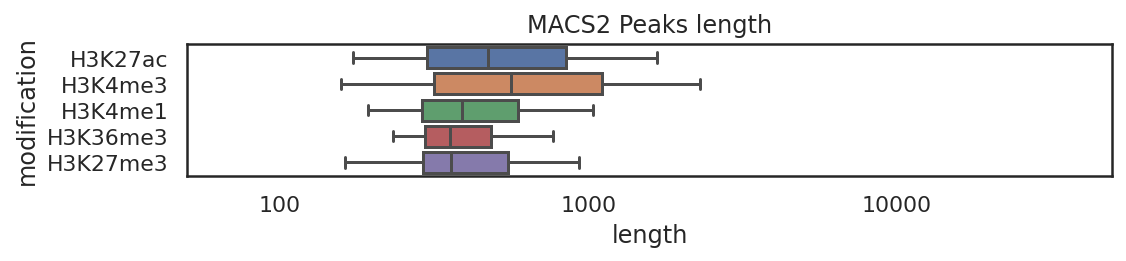

MACS2 broad


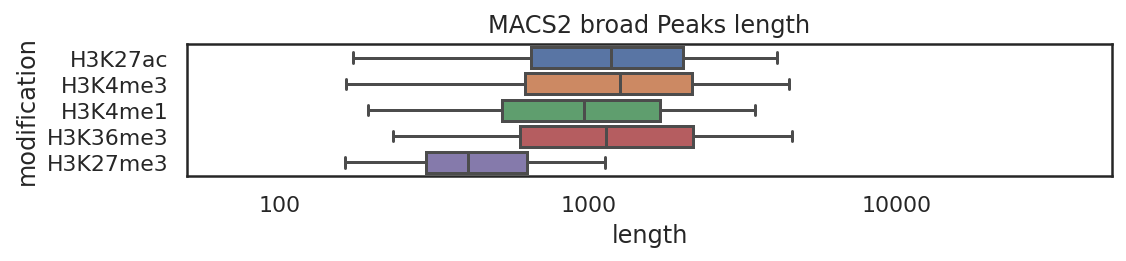

SPAN


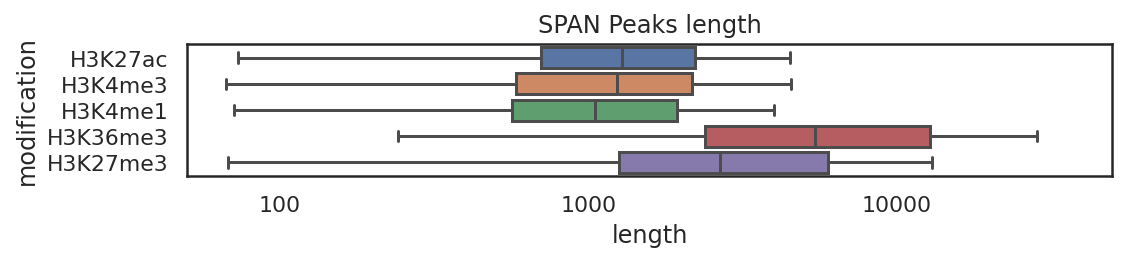

SICER


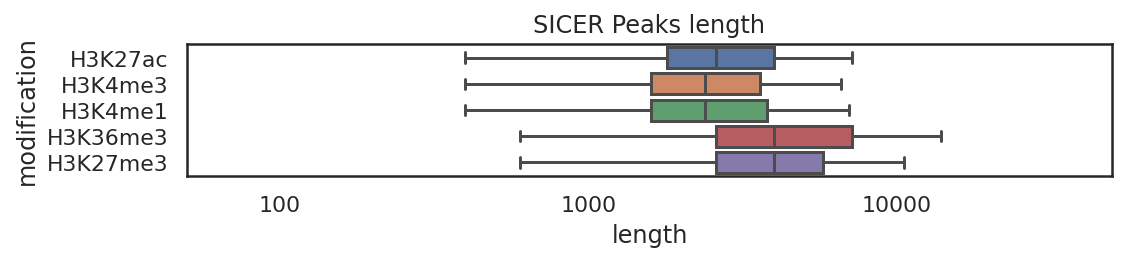

In [38]:
print('GSE26320 REPROCESSED Length of peaks')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_boxes(df_gse26320_peaks[df_gse26320_peaks['tool'] == tool], 'length', f'{tool} Peaks length',
               log=True, bar=False, minx=5e1, maxx=5e4,
               order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
    plt.savefig(f'{GSE26320_PATH}/pics/modifications_{tool}_lengths2.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [39]:
from math import floor

def compute_length_percentiles(ts, steps = 10):
    percentiles = []
    for m in set(ts['modification']):
        tm = ts[ts['modification'] == m].copy()
        tm.sort_values(by=['length'], inplace=True)
        tmn = int(floor(len(tm) / steps))
        for i in range(steps):
            p = int(100 / steps * (i + 1))
            percentiles.extend((m, p, v) for v in tm['length'].values[i * tmn: (i + 1) * tmn])

    return pd.DataFrame(columns=['modification', 'percentile', 'length'], data=percentiles)

def plot_percentiles(df, title, miny=5e1, maxy=1e5):
    percentiles_df = compute_length_percentiles(df)
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    g_results = sns.boxplot(data=percentiles_df, x="percentile", y="length", hue="modification",
                            hue_order=['CTCF', 'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
    sample_count = list(
        filter(lambda y: miny <= y <= maxy,
               [10, 20, 50, 100, 200, 500, 1000, 2000, 5000,
                10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000])
    )
    g_results.set(yscale='log')
    g_results.set(yticks=sample_count)
    g_results.set(yticklabels=sample_count)
    ax.set_ylim(miny, maxy)
    ax.title.set_text(title)

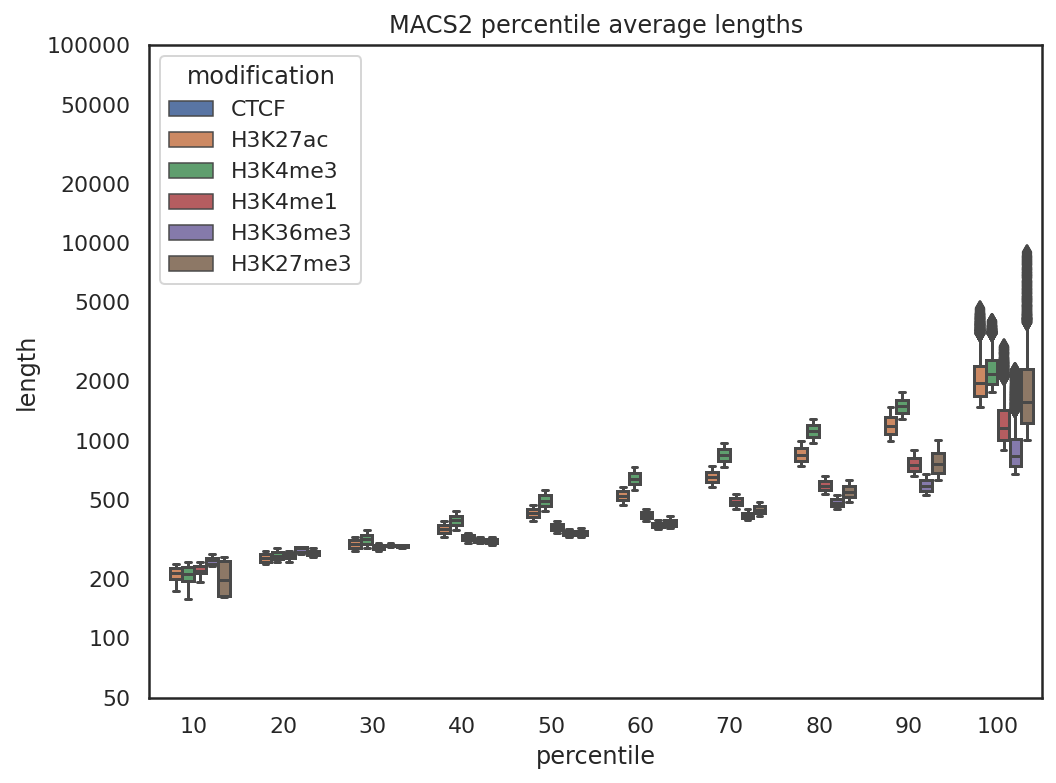

In [40]:
plot_percentiles(df_gse26320_peaks[df_gse26320_peaks['tool'] == 'MACS2'], 'MACS2 percentile average lengths')
plt.show()

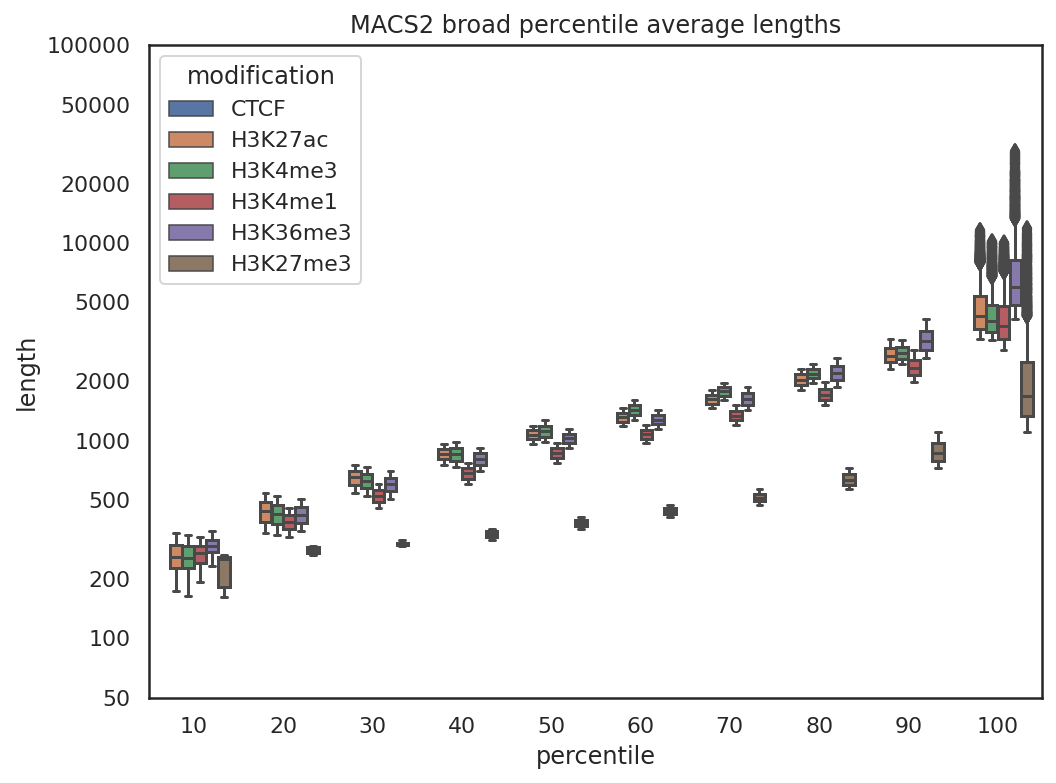

In [41]:
plot_percentiles(df_gse26320_peaks[df_gse26320_peaks['tool'] == 'MACS2 broad'], 'MACS2 broad percentile average lengths')
plt.show()

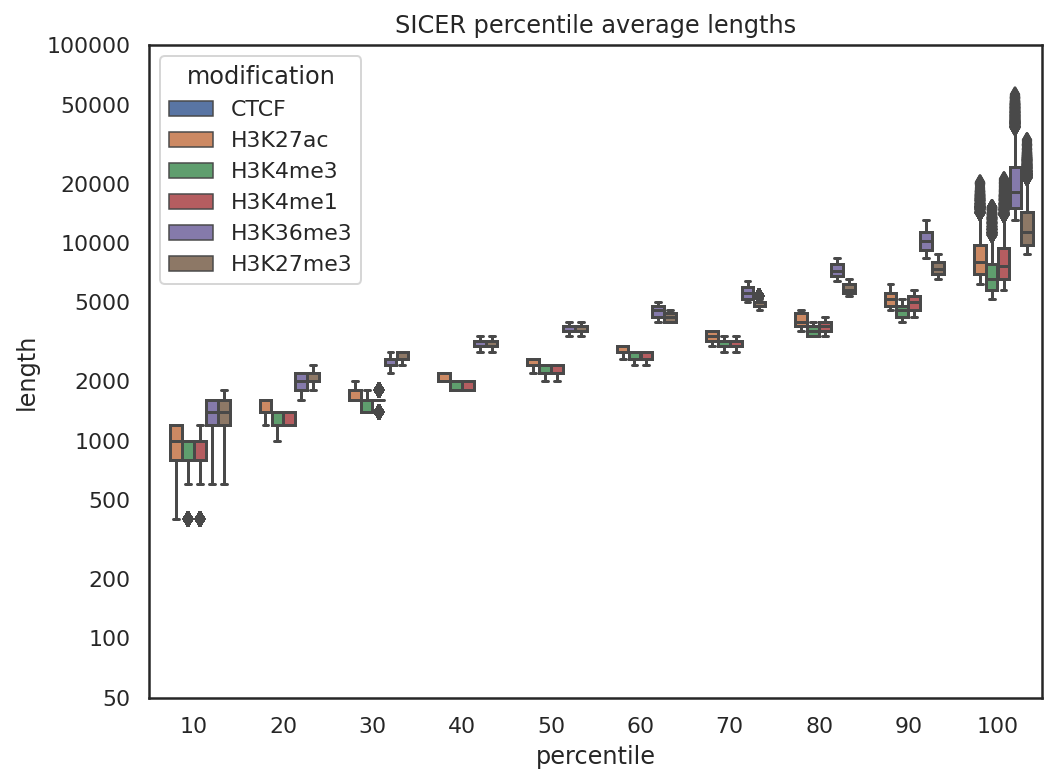

In [42]:
plot_percentiles(df_gse26320_peaks[df_gse26320_peaks['tool'] == 'SICER'], 'SICER percentile average lengths')
plt.show()

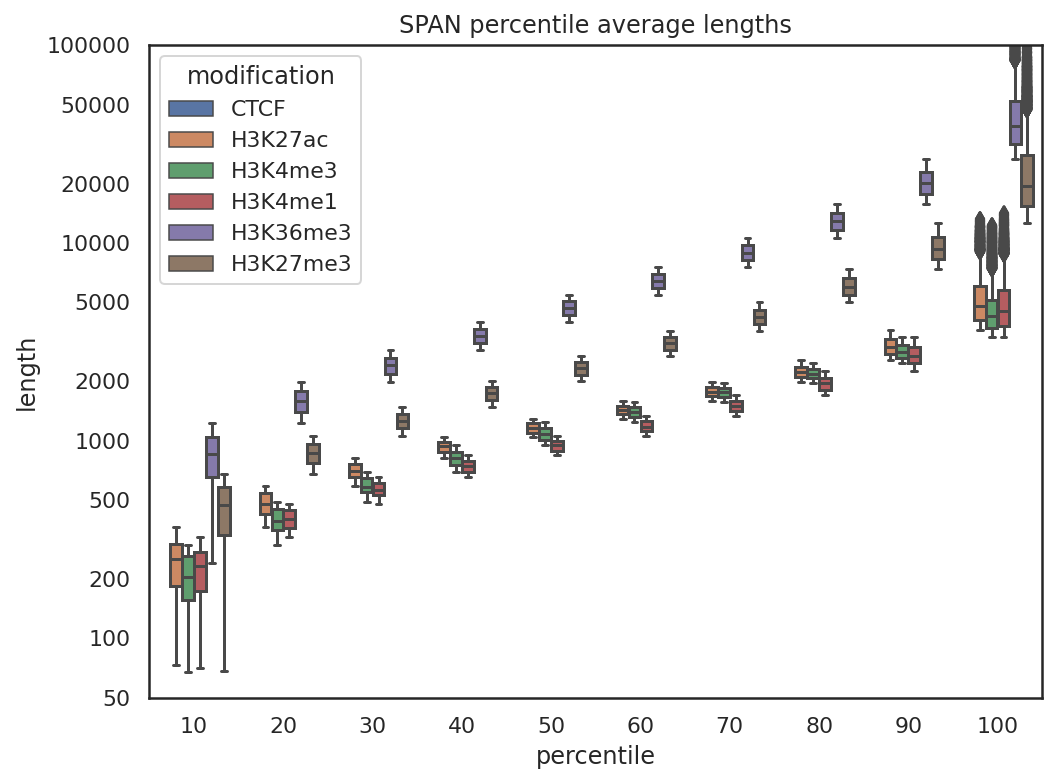

In [43]:
plot_percentiles(df_gse26320_peaks[df_gse26320_peaks['tool'] == 'SPAN'], 'SPAN percentile average lengths')
plt.show()

# Distance between peaks

In [44]:
from itertools import product

def distance_between_peaks(df, hue='modification'):
    distances = []
    for (m, t, f), dft in tqdm(df.groupby([hue, 'tool', 'file'])):
        for chr in sorted(set(dft['chromosome'])):
            dftc = dft[dft['chromosome'] == chr].copy().sort_values(by=['start'])
            starts = dftc['start']
            ends = dftc['end']
            ends = np.roll(ends, 1)
            ds = starts - ends
            # Ignore first and last
            distances.extend((m, t, f, chr, d) for d in ds[1: ds.size - 1])
    return pd.DataFrame(columns=[hue, 'tool', 'file', 'chr', 'distance'], data=distances)

In [45]:
df_gse26320_distances = distance_between_peaks(df_gse26320_peaks)
df_gse26320_distances

  0%|          | 0/334 [00:00<?, ?it/s]

modification   tool  \
0            H3K27ac  MACS2   
1            H3K27ac  MACS2   
2            H3K27ac  MACS2   
3            H3K27ac  MACS2   
4            H3K27ac  MACS2   
...              ...    ...   
3094311      H3K4me3   SPAN   
3094312      H3K4me3   SPAN   
3094313      H3K4me3   SPAN   
3094314      H3K4me3   SPAN   
3094315      H3K4me3   SPAN   

                                                      file   chr  distance  
0        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  chr1      2645  
1        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  chr1     15006  
2        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  chr1       203  
3        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  chr1     74023  
4        /home/jetbrains/data/2023_GSE26320/macs2/GSM64...  chr1    110280  
...                                                    ...   ...       ...  
3094311  /home/jetbrains/data/2023_GSE26320/span/GSM646...  chrX      4044  
3094312  /home/jetbrains/data/2023_GSE26320/span/GSM646...  chrX    199348  
3094313  /home/jetbrains/data/2023_GSE26320/span/GSM646...  chrX     53028  
3094314  /home/jetbrains/data/2023_GSE26320/span/GSM646...  chrX    220079  
3094315  /home/jetbrains/data/2023_GSE26320/span/GSM646...  chrX     28872  

[3094316 rows x 5 columns]

GSE26320 REPROCESSED Length of peaks
MACS2


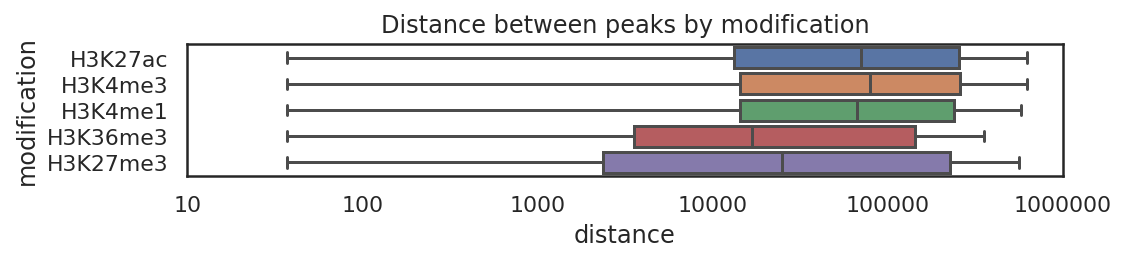

MACS2 broad


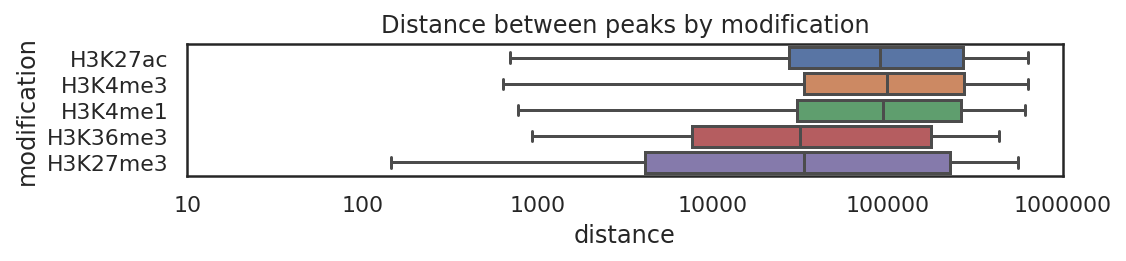

SPAN


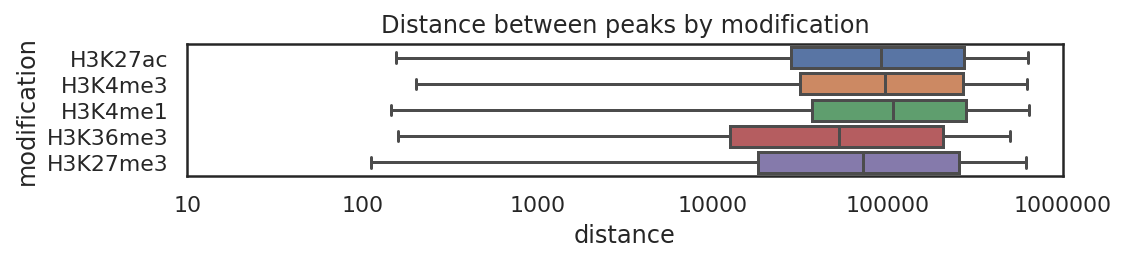

SICER


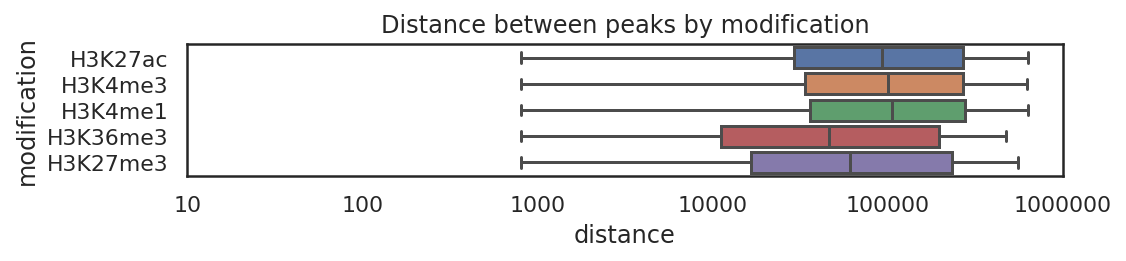

In [46]:
print('GSE26320 REPROCESSED Length of peaks')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_boxes(df_gse26320_distances[df_gse26320_distances['tool'] == tool],
               'distance', 'Distance between peaks by modification',
               log=True, minx=10, maxx=1e6,
               order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
    plt.show()

GSE26320 REPROCESSED Length of peaks
MACS2


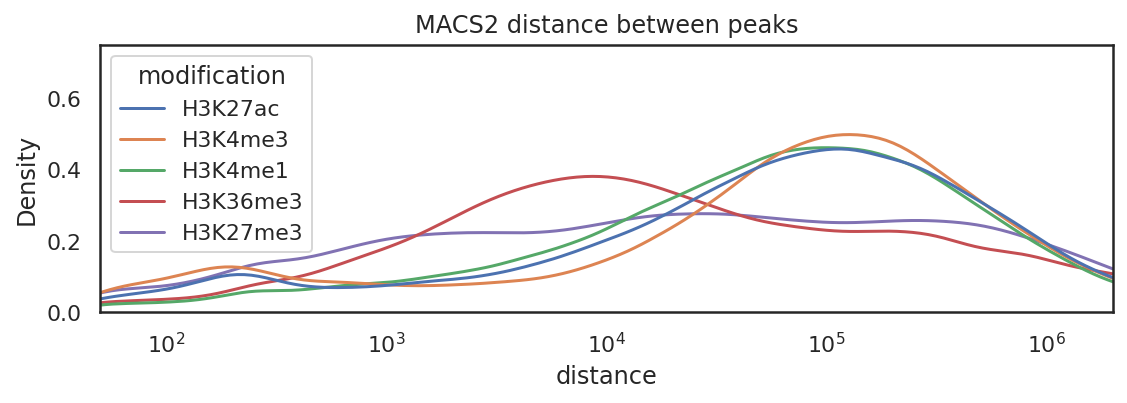

MACS2 broad


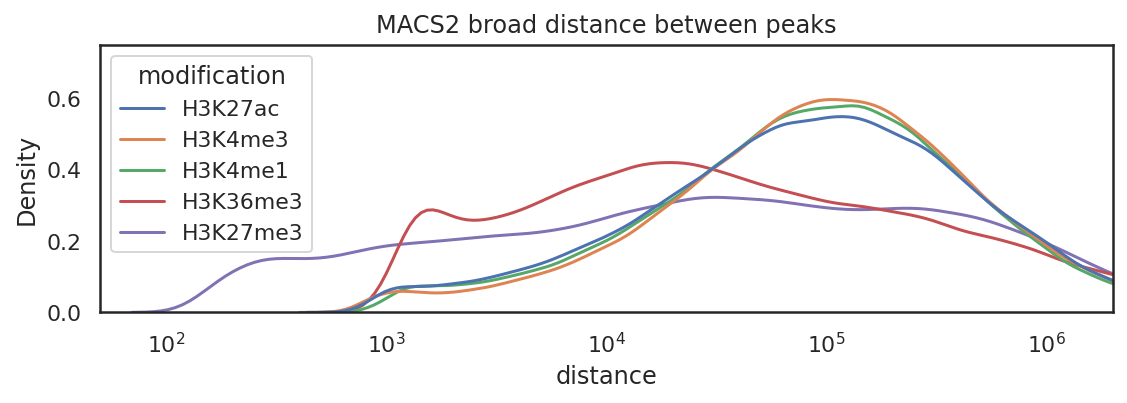

SPAN


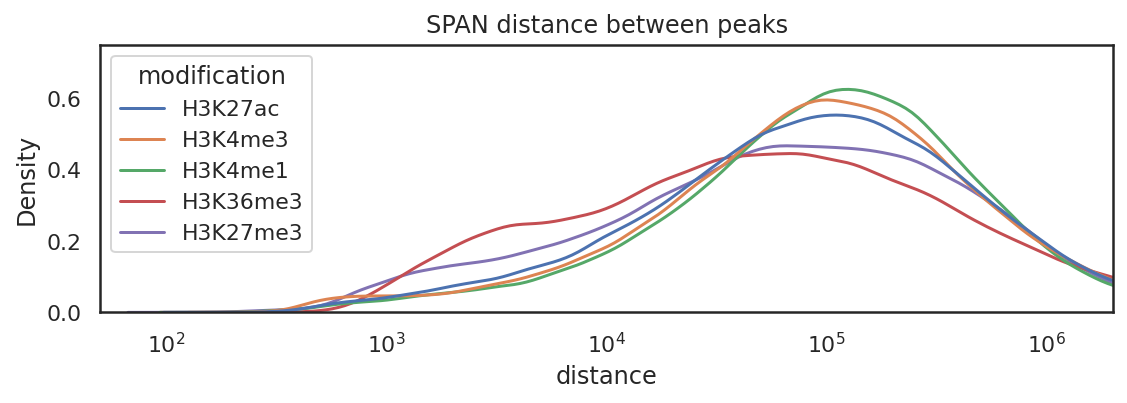

SICER


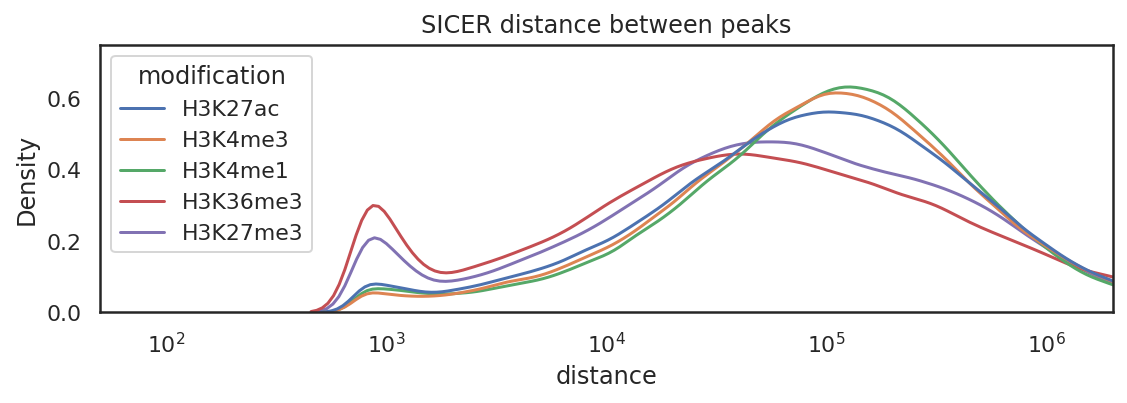

In [47]:
print('GSE26320 REPROCESSED Length of peaks')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_kde(df_gse26320_distances[df_gse26320_distances['tool'] == tool],
             'distance', f'{tool} distance between peaks',
             order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
             minx=50, maxx=2e6, maxy=0.75)
    plt.savefig(f'{GSE26320_PATH}/pics/distance_{tool}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# hg38 genes length and distance between genes

GSE26320 Lengths of peaks and genes
MACS2


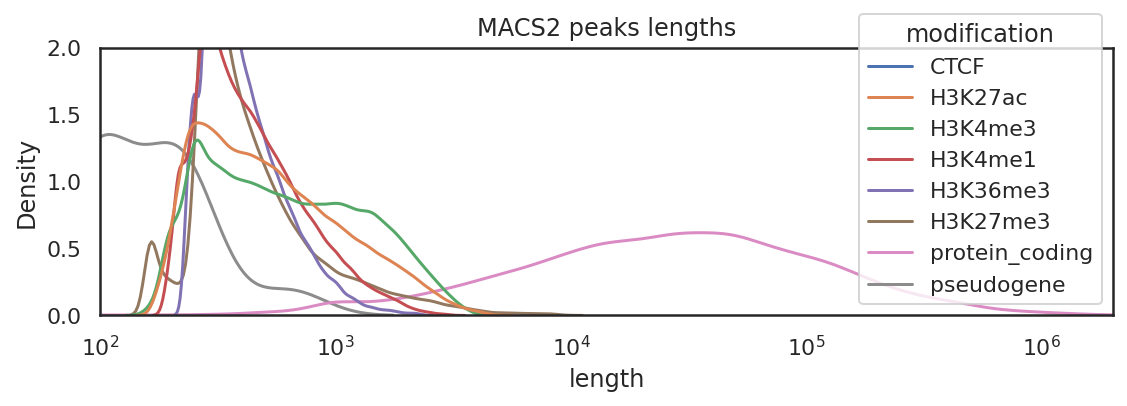

MACS2 broad


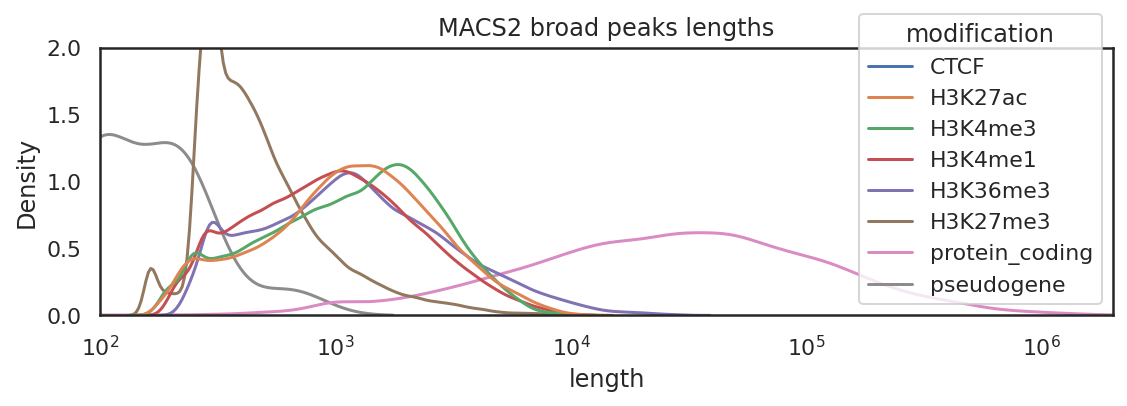

SPAN


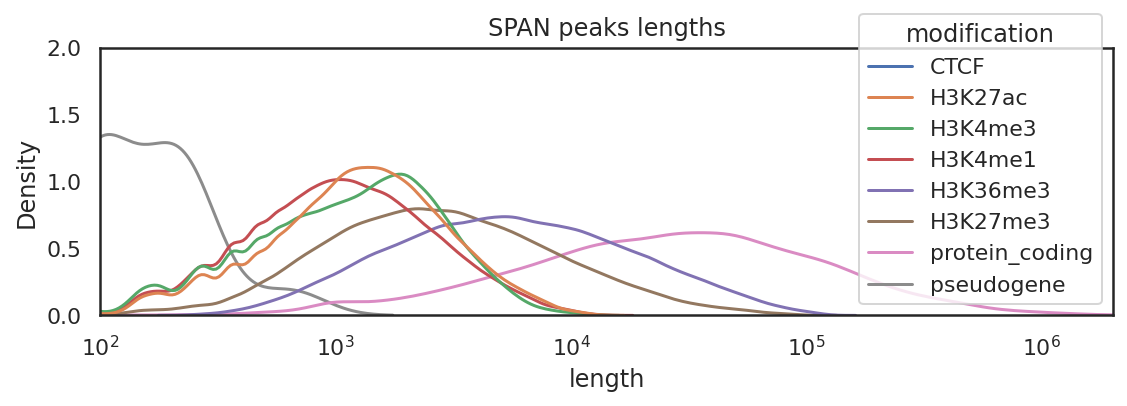

SICER


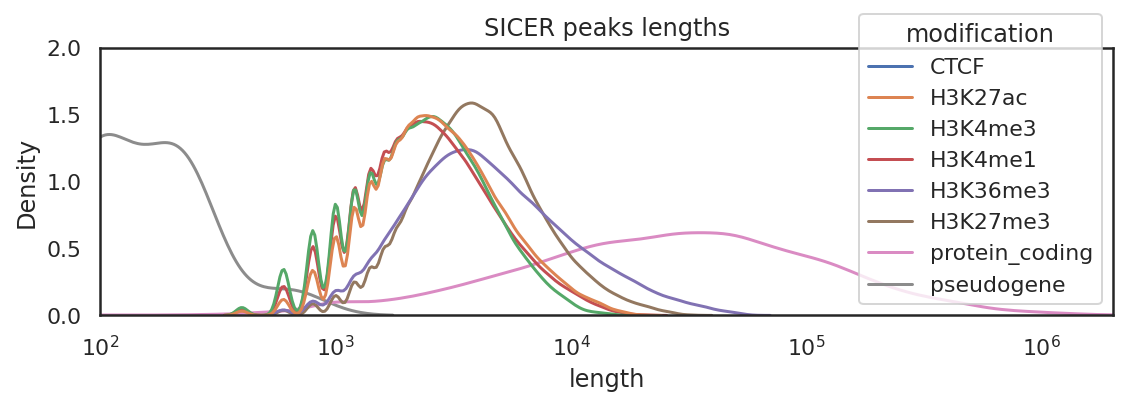

In [53]:
print('GSE26320 Lengths of peaks and genes')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    ts = df_gse26320_peaks[df_gse26320_peaks['tool'] == tool]
    tss = pd.concat([ts, gtf_genes_df2.rename({'gene_type': 'modification'}, axis=1)]).reset_index()
    plot_kde(tss,
             'length', f'{tool} peaks lengths',
             order=['CTCF', 'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'] + GENES_TYPES,
             minx=100, maxx=2e6, maxy=2)
    plt.savefig(f'{GSE26320_PATH}/pics/modifications_genes_{tool}_lengths.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [54]:
gtf_genes_df_distances = distance_between_peaks(gtf_genes_df2, hue='gene_type')
gtf_genes_df_distances

  0%|          | 0/2 [00:00<?, ?it/s]

gene_type tool file   chr  distance
0      protein_coding  gtf  gtf  chr1    379155
1      protein_coding  gtf  gtf  chr1    234038
2      protein_coding  gtf  gtf  chr1    237269
3      protein_coding  gtf  gtf  chr1      -372
4      protein_coding  gtf  gtf  chr1      1275
...               ...  ...  ...   ...       ...
19966  protein_coding  gtf  gtf  chrY     53927
19967      pseudogene  gtf  gtf  chr1       223
19968      pseudogene  gtf  gtf  chr1     11401
19969      pseudogene  gtf  gtf  chr1     12843
19970      pseudogene  gtf  gtf  chr7     25482

[19971 rows x 5 columns]

Distance between genes


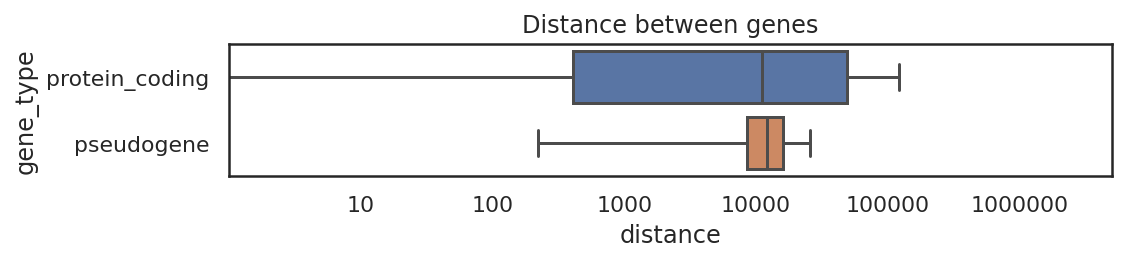

In [55]:
print('Distance between genes')
plot_boxes(gtf_genes_df_distances, 'distance', 'Distance between genes', hue='gene_type',
           log=True, minx=1, maxx=5e6,
           order=GENES_TYPES)
plt.show()

Distance between genes


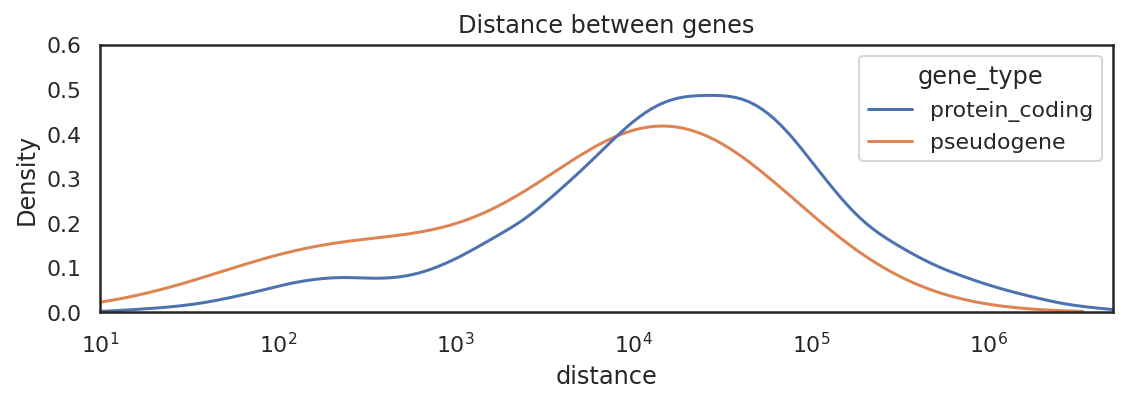

In [56]:
print('Distance between genes')
plot_kde(gtf_genes_df_distances[gtf_genes_df_distances['distance'] > 10],
         'distance', 'Distance between genes', hue='gene_type',
         order=GENES_TYPES,
         minx=10, maxx=5e6, maxy=0.6)
plt.show()

GSE26320 Distances between peaks and genes
MACS2


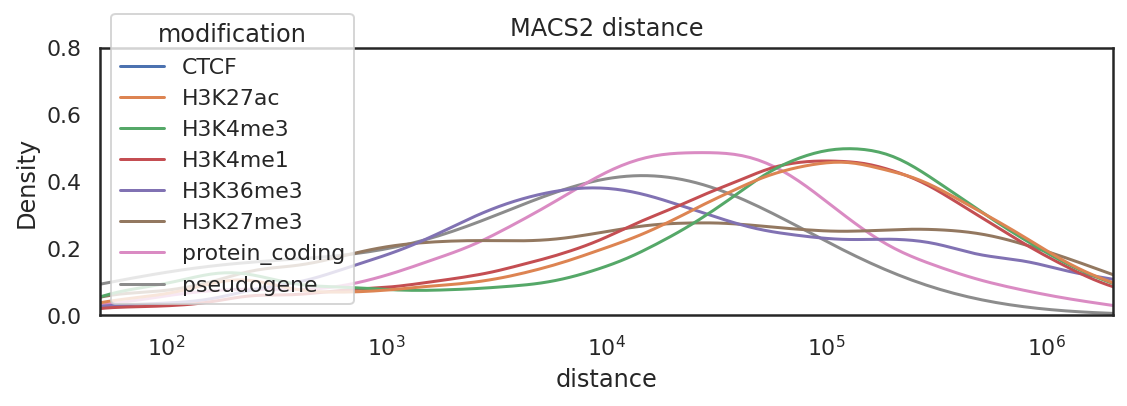

MACS2 broad


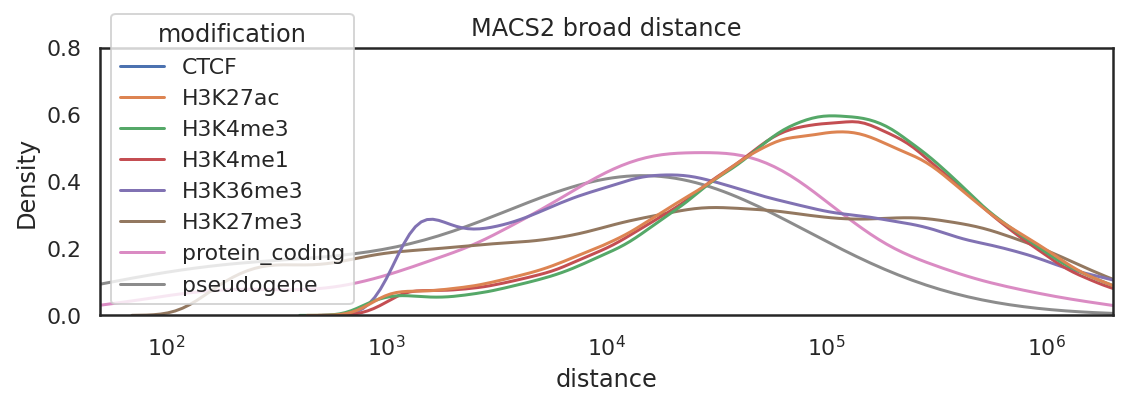

SPAN


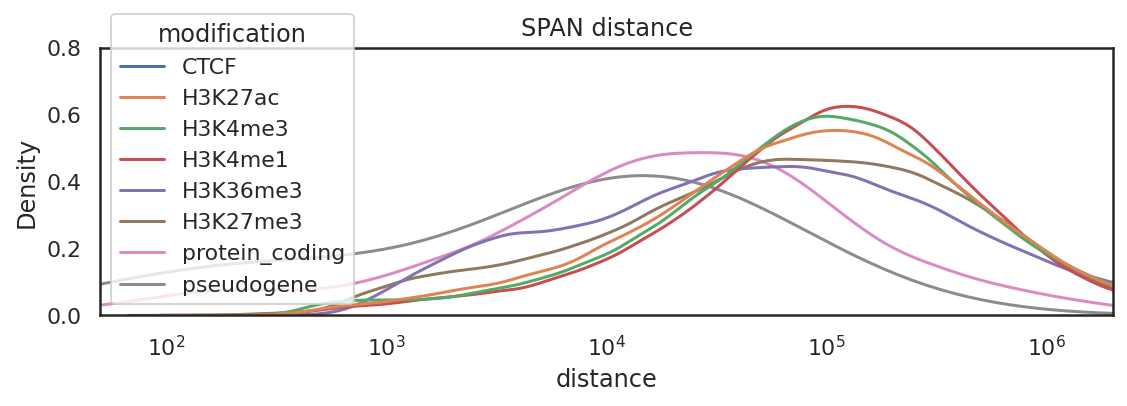

SICER


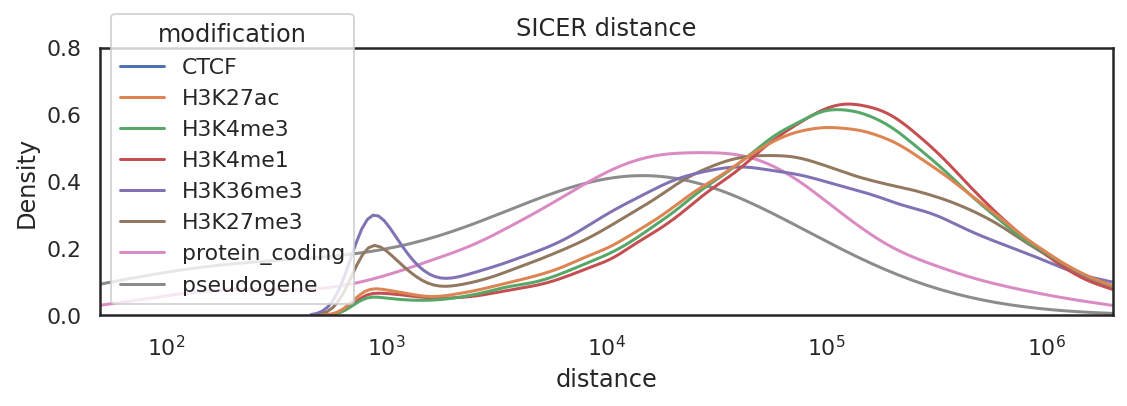

In [57]:
print('GSE26320 Distances between peaks and genes')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    ts = df_gse26320_distances[df_gse26320_distances['tool'] == tool]
    tss = pd.concat([ts, gtf_genes_df_distances.rename({'gene_type': 'modification'}, axis=1)]).reset_index()
    tss = tss[tss['distance'] > 10]
    plot_kde(tss,
             'distance', f'{tool} distance',
             order=['CTCF', 'H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'] + GENES_TYPES,
             minx=50, maxx=2e6, maxy=0.8)
    plt.savefig(f'{GSE26320_PATH}/pics/distances_genes_{tool}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Immgen ATAC-seq reprocessed

In [58]:
IMMGEN_PATH = os.path.expanduser('~/data/2022_Immgen')
IMMGEN_CELLS = ['Monocyte']
IMMGEN_MODIFICATIONS = ['ATAC']

IMMGEN_MACS2_DIR = os.path.join(IMMGEN_PATH, os.path.expanduser('macs2'))
# MACS2_FDRS = ['0.1', '0.01', '0.05', '1e-3', '1-e4', '1e-6', '1e-8', '1e-10']
MACS2_FDRS = ['0.05']
df_immgen = find_peak_files(IMMGEN_MACS2_DIR, '.narrowPeak', IMMGEN_CELLS, IMMGEN_MODIFICATIONS, [''], MACS2_FDRS)
df_immgen['tool'] = 'MACS2'
df_immgen['dir'] = IMMGEN_MACS2_DIR
df_immgen.sample(3)

  0%|          | 0/9 [00:00<?, ?it/s]

modification      cell replicate   fdr  \
1         ATAC  Monocyte            0.05   
0         ATAC  Monocyte            0.05   
2         ATAC  Monocyte            0.05   

                                                file   tool  \
1  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...  MACS2   
0  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...  MACS2   
2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...  MACS2   

                                      dir  
1  /home/jetbrains/data/2022_Immgen/macs2  
0  /home/jetbrains/data/2022_Immgen/macs2  
2  /home/jetbrains/data/2022_Immgen/macs2

In [59]:
ts = load_peaks(df_immgen)
ts

0it [00:00, ?it/s]

modification   tool                                               file  \
0             ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
1             ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
2             ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
3             ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
4             ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
...            ...    ...                                                ...   
29594         ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
29595         ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
29596         ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
29597         ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   
29598         ATAC  MACS2  /home/jetbrains/data/2022_Immgen/macs2/SRR5799...   

      chromosome      start        end  length  
0          chr11   83658946   83659103     157  
1           chr5   99363060   99363585     525  
2           chr3   37567253   37567566     313  
3           chr8   94370782   94371142     360  
4           chr9   53693840   53693991     151  
...          ...        ...        ...     ...  
29594       chr4  129394213  129394317     104  
29595       chr3   96300696   96300996     300  
29596       chr7   98584703   98584787      84  
29597      chr12   55361058   55361253     195  
29598       chr8   79226187   79226315     128  

[29599 rows x 7 columns]

Immgen MACS2 REPROCESSED Length of peaks


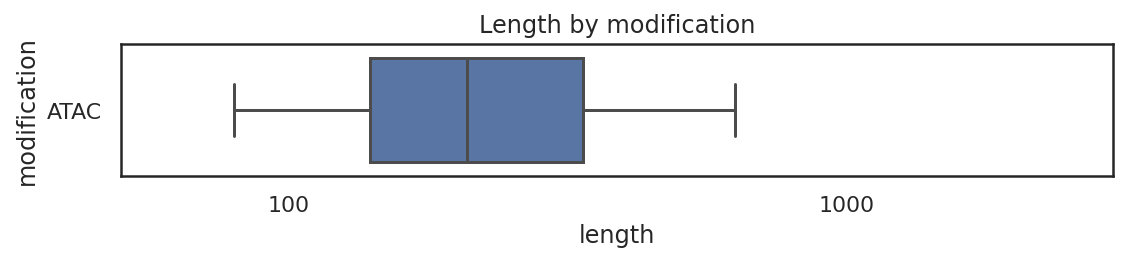

In [60]:
print('Immgen MACS2 REPROCESSED Length of peaks')
plot_boxes(ts, 'length', 'Length by modification',
           log=True, minx=5e1, maxx=3e3)
plt.show()

Immgen MACS2 REPROCESSED Length of peaks


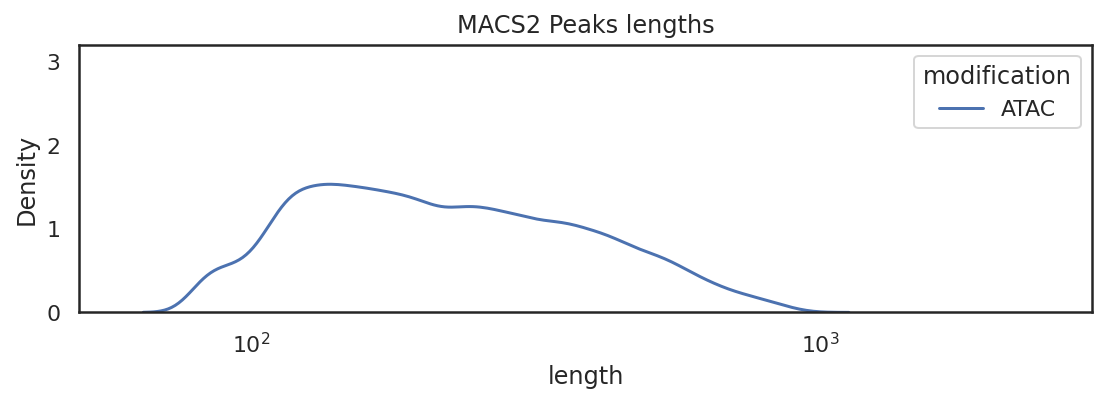

In [61]:
print('Immgen MACS2 REPROCESSED Length of peaks')
plot_kde(ts, 'length', 'MACS2 Peaks lengths', minx=5e1, maxx=3e3, maxy=3.2)
plt.show()

In [62]:
IMMGEN_SPAN_DIR = os.path.join(IMMGEN_PATH, 'span')
# MACS2_FDRS = ['0.1', '0.01', '0.05', '1e-3', '1-e4', '1e-6', '1e-8', '1e-10']
df_immgen_span = find_peak_files(IMMGEN_SPAN_DIR, '.peak', IMMGEN_CELLS, IMMGEN_MODIFICATIONS, [''], MACS2_FDRS)
df_immgen_span['tool'] = 'SPAN'
df_immgen_span['dir'] = IMMGEN_SPAN_DIR
df_immgen_span

  0%|          | 0/4 [00:00<?, ?it/s]

modification      cell replicate   fdr  \
0         ATAC  Monocyte            0.05   
1         ATAC  Monocyte            0.05   
2         ATAC  Monocyte            0.05   

                                                file  tool  \
0  /home/jetbrains/data/2022_Immgen/span/SRR57994...  SPAN   
1  /home/jetbrains/data/2022_Immgen/span/SRR57994...  SPAN   
2  /home/jetbrains/data/2022_Immgen/span/SRR57994...  SPAN   

                                     dir  
0  /home/jetbrains/data/2022_Immgen/span  
1  /home/jetbrains/data/2022_Immgen/span  
2  /home/jetbrains/data/2022_Immgen/span

In [63]:
ts = load_peaks(df_immgen_span)
ts

0it [00:00, ?it/s]

modification  tool                                               file  \
0             ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
1             ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
2             ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
3             ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
4             ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
...            ...   ...                                                ...   
29415         ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
29416         ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
29417         ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
29418         ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   
29419         ATAC  SPAN  /home/jetbrains/data/2022_Immgen/span/SRR57994...   

      chromosome      start        end  length  
0           chr1  131138241  131138494     253  
1           chr6  140815932  140816079     147  
2          chr14   51103408   51103550     142  
3          chr11   72795721   72796181     460  
4           chr3  149380113  149380453     340  
...          ...        ...        ...     ...  
29415      chr10  125317300  125317694     394  
29416      chr18   90583305   90583377      72  
29417      chr18   12740629   12741897    1268  
29418       chr6   85306525   85306596      71  
29419      chr17   14961208   14961275      67  

[29420 rows x 7 columns]

Immgen SPAN REPROCESSED Length of peaks


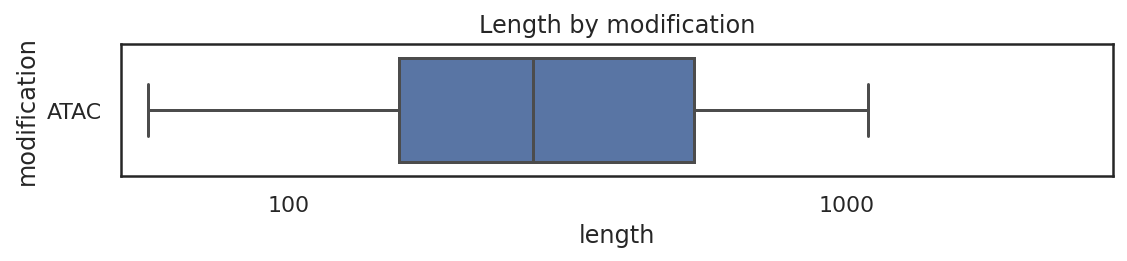

In [64]:
print('Immgen SPAN REPROCESSED Length of peaks')
plot_boxes(ts, 'length', 'Length by modification',
           log=True, minx=5e1, maxx=3e3)
plt.show()

Immgen SPAN REPROCESSED Length of peaks


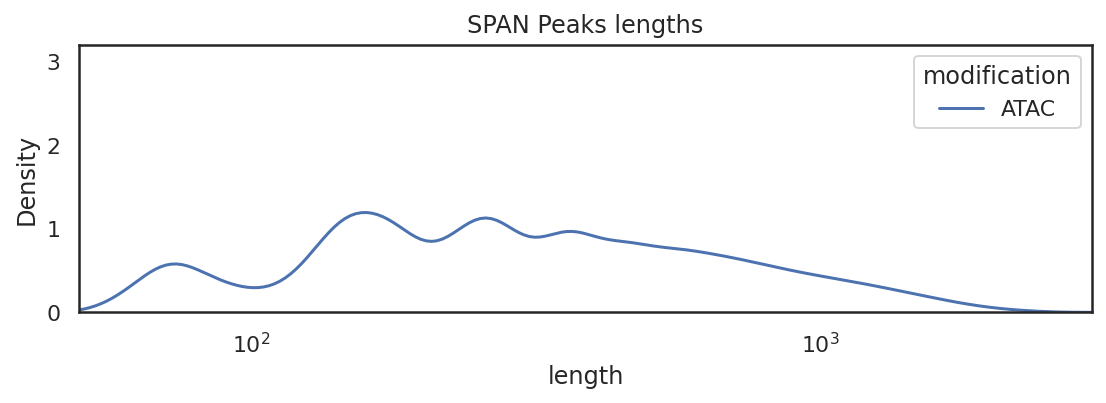

In [65]:
print('Immgen SPAN REPROCESSED Length of peaks')
plot_kde(ts, 'length', 'SPAN Peaks lengths', minx=5e1, maxx=3e3, maxy=3.2)
plt.show()

# Theoretical peaks length

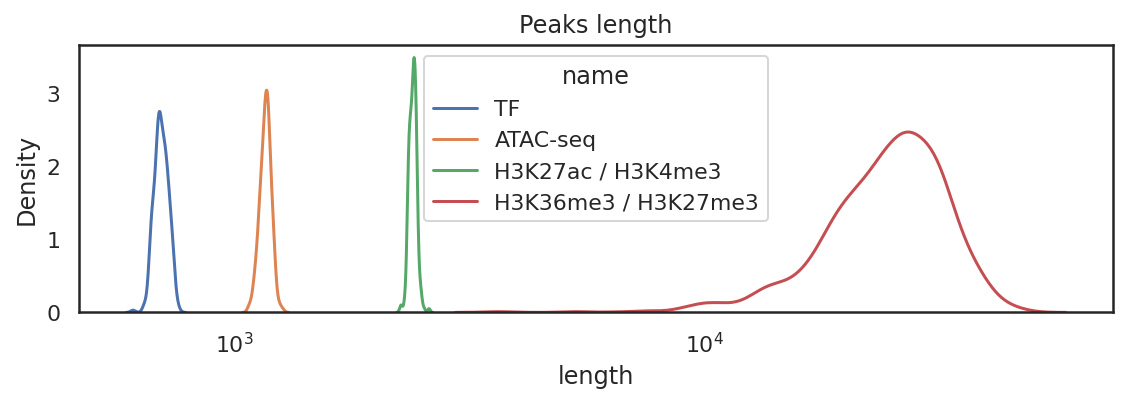

In [66]:
data = {
    'TF': np.random.negative_binomial(2000, 0.8, size=300) + 200,
    'ATAC-seq': np.random.negative_binomial(1000, 0.6, size=250) + 500,
    'H3K27ac / H3K4me3':  np.random.negative_binomial(100, 0.2, size=200) + 2000,
    'H3K36me3 / H3K27me3': np.random.negative_binomial(5000, 0.4, size=2000)  * 50 - 350000,
}
t = pd.concat([
    pd.DataFrame(data=dict(name=[name] * len(vals), length=vals))
    for name, vals in data.items()
]).reset_index(drop=True)

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.kdeplot(data=t, x='length', hue='name',
            common_norm=True,
            log_scale=True,
            ax=ax
            )

# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
plt.title('Peaks length')
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))

plt.tight_layout()
# ax.legend(loc='upper right')
plt.savefig(f'{GSE26320_PATH}/pics/theoretical_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Peaks length for RoadmapEpigenomics

In [67]:
PATH = os.path.expanduser('~/data/2023_Immune')

IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3']


In [68]:
df_roadmap_macs2 = find_peak_files(
    os.path.join(PATH, 'macs2'), '.narrowPeak', IMMUNE_CELLS, MODIFICATIONS, [''], ['0.05']
)
df_roadmap_macs2['tool'] = 'MACS2'
print('MACS2', len(df_roadmap_macs2))

df_roadmap_macs2broad = find_peak_files(
    os.path.join(PATH, 'macs2'), '.broadPeak', IMMUNE_CELLS, MODIFICATIONS,  [''], ['0.1']
)
df_roadmap_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_roadmap_macs2broad))

df_roadmap_sicer = find_peak_files(
    os.path.join(PATH, 'sicer'), 'summary-FDR', IMMUNE_CELLS, MODIFICATIONS, [''], ['0.01']
)
df_roadmap_sicer['tool'] = 'SICER'
print('SICER', len(df_roadmap_sicer))

df_roadmap_span = find_peak_files(
    os.path.join(PATH, 'span'), '.peak', IMMUNE_CELLS, MODIFICATIONS, [''], ['0.05']
)
df_roadmap_span['tool'] = 'SPAN'
print('SPAN', len(df_roadmap_span))

df_roadmap = pd.concat(
    [df_roadmap_macs2, df_roadmap_macs2broad, df_roadmap_sicer, df_roadmap_span]
).reset_index(drop=True)
df_roadmap.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 14


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 14


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 14


  0%|          | 0/15 [00:00<?, ?it/s]

SPAN 14


modification      cell replicate   fdr  \
26      H3K4me3     TCell             0.1   
6      H3K36me3  Monocyte            0.05   
11      H3K4me3     BCell            0.05   
45      H3K27ac     TCell            0.05   
46      H3K4me1     TCell            0.05   

                                                 file         tool  
26  /home/jetbrains/data/2023_Immune/macs2/TCell_H...  MACS2 broad  
6   /home/jetbrains/data/2023_Immune/macs2/Monocyt...        MACS2  
11  /home/jetbrains/data/2023_Immune/macs2/BCell_H...        MACS2  
45  /home/jetbrains/data/2023_Immune/span/TCell_H3...         SPAN  
46  /home/jetbrains/data/2023_Immune/span/TCell_H3...         SPAN

In [69]:
df_roadmap_peaks = load_peaks(df_roadmap)
df_roadmap_peaks

0it [00:00, ?it/s]

modification   tool                                               file  \
0           H3K4me1  MACS2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...   
1           H3K4me1  MACS2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...   
2           H3K4me1  MACS2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...   
3           H3K4me1  MACS2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...   
4           H3K4me1  MACS2  /home/jetbrains/data/2023_Immune/macs2/TCell_H...   
...             ...    ...                                                ...   
552175     H3K36me3   SPAN  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
552176     H3K36me3   SPAN  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
552177     H3K36me3   SPAN  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
552178     H3K36me3   SPAN  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
552179     H3K36me3   SPAN  /home/jetbrains/data/2023_Immune/span/BCell_H3...   

       chromosome      start        end  length  
0            chr5  139354794  139355110     316  
1           chr11  117068434  117068749     315  
2            chr2  136162240  136162477     237  
3            chr4   38680957   38681290     333  
4            chr5   80146114   80146312     198  
...           ...        ...        ...     ...  
552175       chr2  119931604  119979700   48096  
552176       chr9  105356350  105372395   16045  
552177       chr6    2854373    2859992    5619  
552178       chr3   97933505   97934587    1082  
552179      chr12   59687450   59690375    2925  

[552180 rows x 7 columns]

RoadmapEpigenomics REPROCESSED  Length of peaks


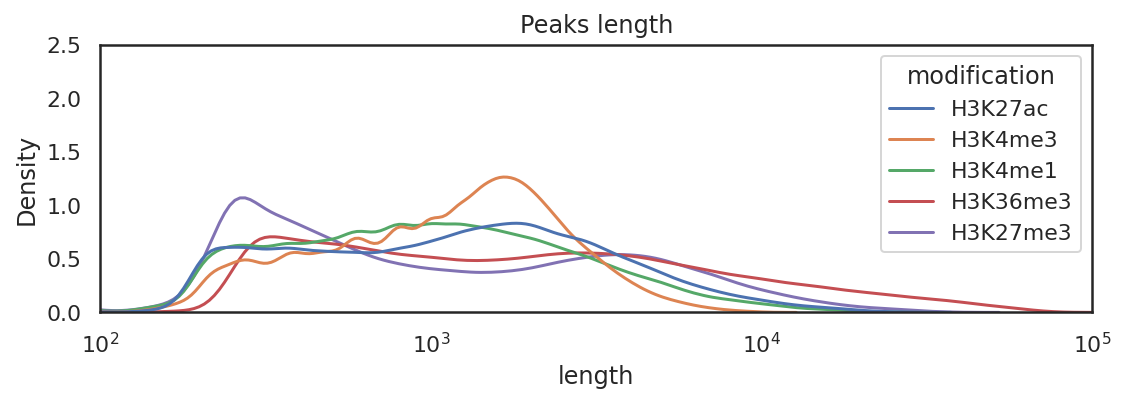

In [70]:
print('RoadmapEpigenomics REPROCESSED  Length of peaks')
plot_kde(df_roadmap_peaks, 'length', 'Peaks length',
         order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
         minx=1e2, maxx=1e5)
plt.savefig(f'{PATH}/pics/modifications_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

MACS2


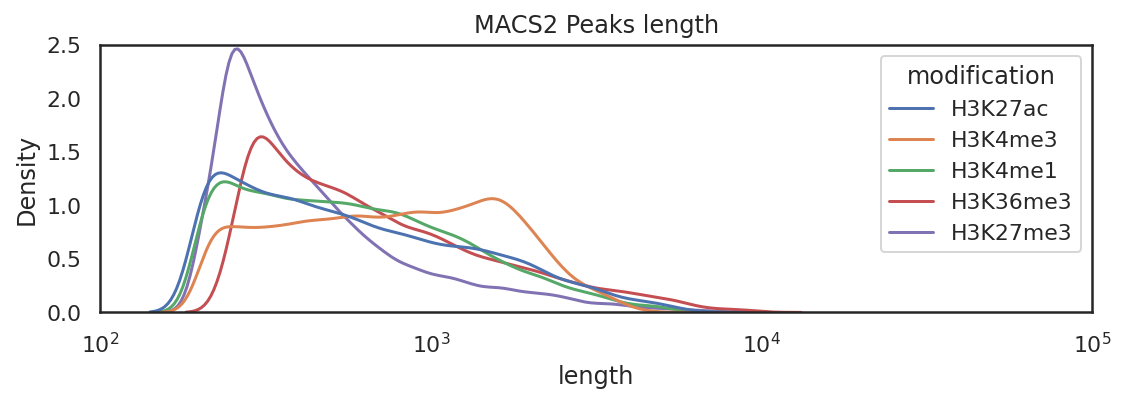

MACS2 broad


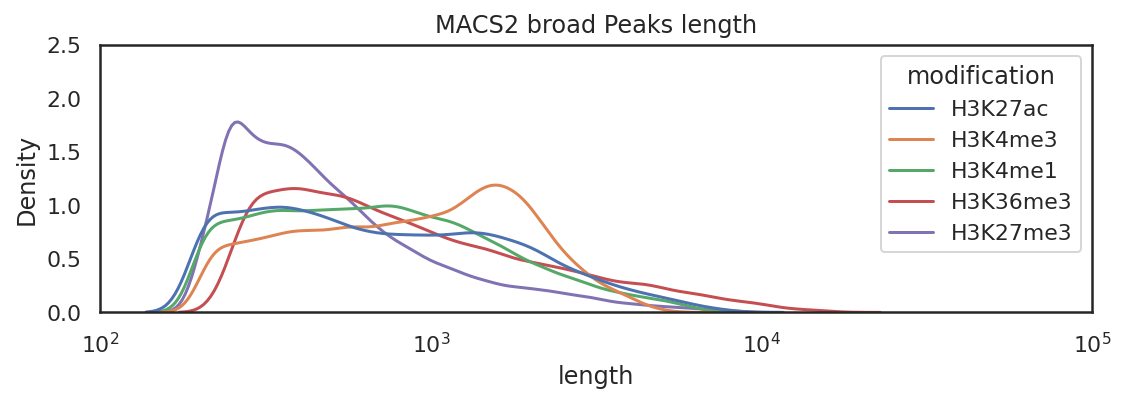

SPAN


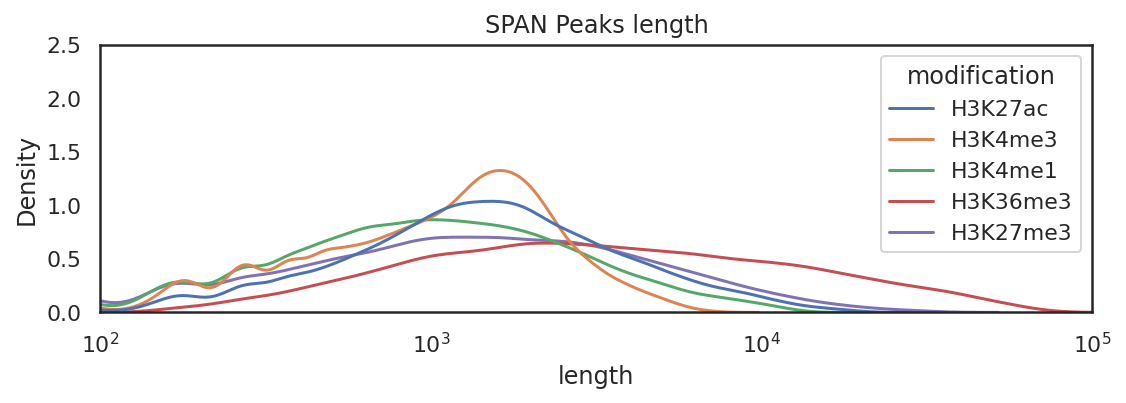

SICER


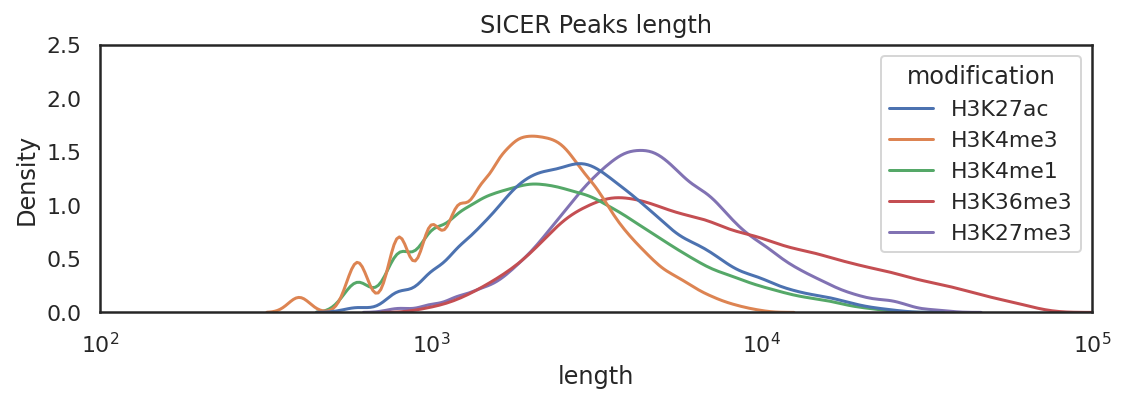

In [71]:
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_kde(df_roadmap_peaks[df_roadmap_peaks['tool'] == tool], 'length', f'{tool} Peaks length',
             order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
             minx=1e2, maxx=1e5)
    plt.savefig(f'{PATH}/pics/modifications_{tool}_lengths.pdf', bbox_inches='tight', dpi=300)
    plt.show()

MACS2


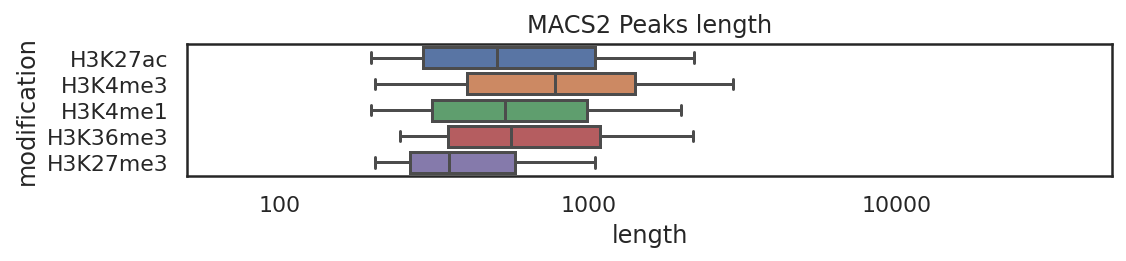

MACS2 broad


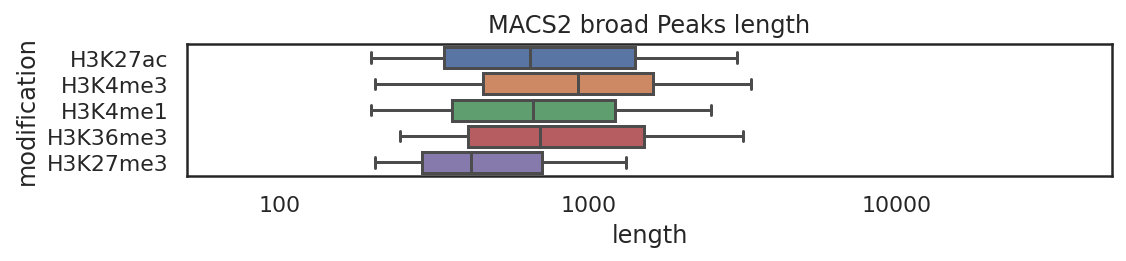

SPAN


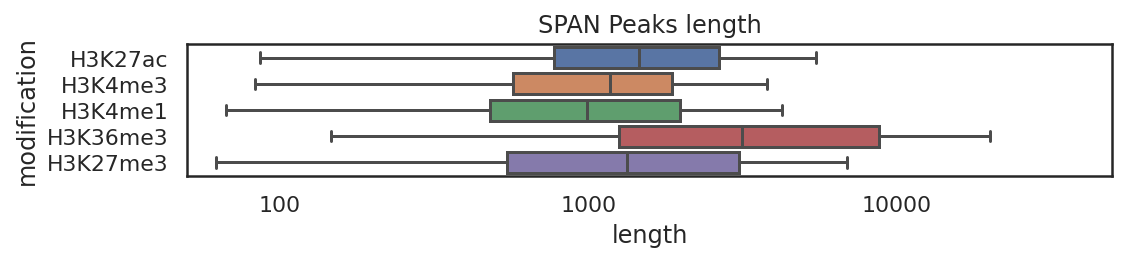

SICER


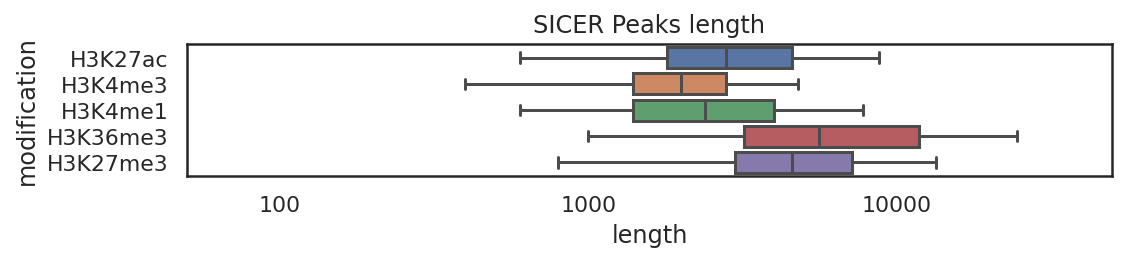

In [72]:
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_boxes(df_roadmap_peaks[df_roadmap_peaks['tool'] == tool], 'length', f'{tool} Peaks length',
               log=True, minx=5e1, maxx=5e4,
               order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
    plt.savefig(f'{PATH}/pics/modifications_{tool}_lengths2.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [73]:
df_roadmap_distances = distance_between_peaks(df_roadmap_peaks)
df_roadmap_distances

  0%|          | 0/56 [00:00<?, ?it/s]

modification   tool                                               file  \
0           H3K27ac  MACS2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
1           H3K27ac  MACS2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
2           H3K27ac  MACS2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
3           H3K27ac  MACS2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
4           H3K27ac  MACS2  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
...             ...    ...                                                ...   
549251      H3K4me3   SPAN  /home/jetbrains/data/2023_Immune/span/TCell_H3...   
549252      H3K4me3   SPAN  /home/jetbrains/data/2023_Immune/span/TCell_H3...   
549253      H3K4me3   SPAN  /home/jetbrains/data/2023_Immune/span/TCell_H3...   
549254      H3K4me3   SPAN  /home/jetbrains/data/2023_Immune/span/TCell_H3...   
549255      H3K4me3   SPAN  /home/jetbrains/data/2023_Immune/span/TCell_H3...   

         chr  distance  
0       chr1    529267  
1       chr1     16779  
2       chr1     46474  
3       chr1     28450  
4       chr1      5549  
...      ...       ...  
549251  chrY   2163978  
549252  chrY    828736  
549253  chrY    413901  
549254  chrY  35736552  
549255  chrY      6461  

[549256 rows x 5 columns]

RoadmapEpigenomics REPROCESSED Length of peaks
MACS2


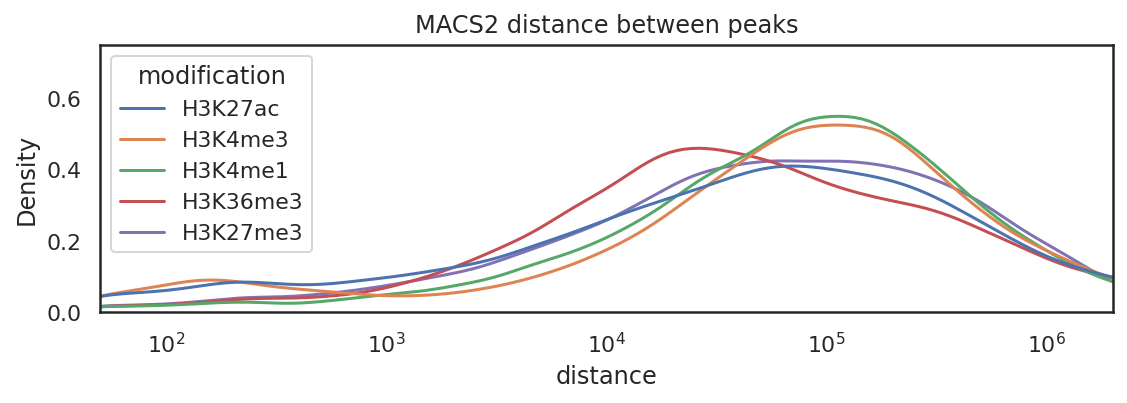

MACS2 broad


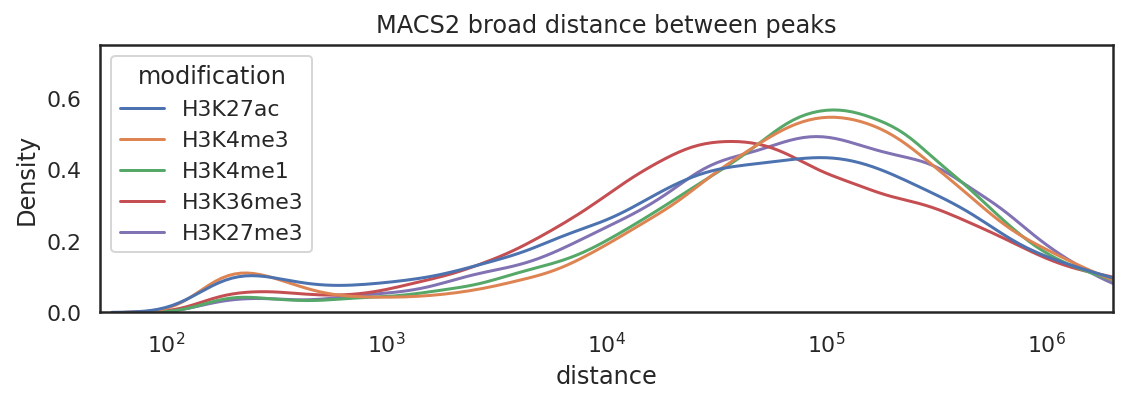

SPAN


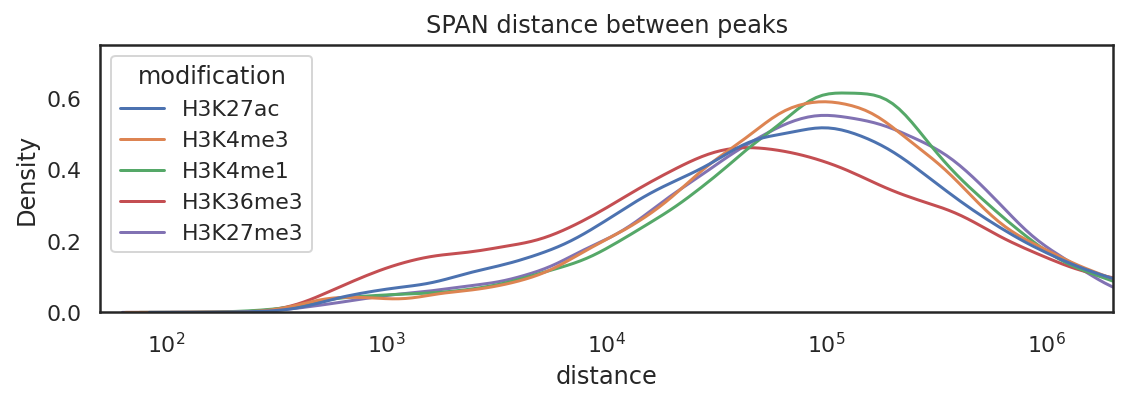

SICER


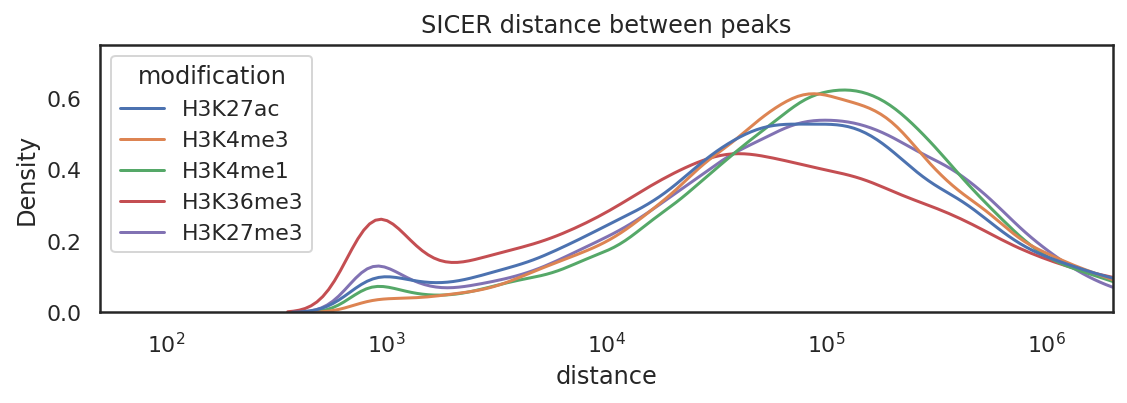

In [74]:
print('RoadmapEpigenomics REPROCESSED Length of peaks')
for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    print(tool)
    plot_kde(df_roadmap_distances[df_roadmap_distances['tool'] == tool],
             'distance', f'{tool} distance between peaks',
             order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'],
             minx=50, maxx=2e6, maxy=0.75)

    plt.savefig(f'{PATH}/pics/distance_{tool}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# END